In [540]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.decomposition import PCA
from pandas import read_pickle
import pickle
from keras.models import model_from_json

# test datasets
from toy_data import Two2DGaussians
from toy_data import TwoAlternating2DGaussians
from toy_data import TwoLinearDynamicalSystems
from motion_data import MotionCaptureData
from coffee_shop_world_data import CoffeeShopWorldData

# hack to import model from parent directory
# TODO fix with proper modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
from models import SEM, KerasLDS, LinearDynamicSystem, KerasMultiLayerPerceptron
from models import KerasSimpleRNN, KerasGRU
from opt.utils import evaluate, randstr


In [1122]:
# Show summary statistics

res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_None_summary.pkl')


# Test summary results

TL;DR Some generalization on coffee shop world with default SEM parameters, vanilla HRRs, and little pretraining, with a **uniform prior** (i.e. maximum likelihood estimation instead of MAP).

## Methods:

I ran Coffee Shop World with **pretraining**. For each test, I first pretrained SEM with a given number of n_iterations (as defined in the Coffee Shop World engine) with n_repeats = 2 for each iteration, with the poetry and fight schemas. So basically data generated by:

```
python run_engine.py poetry fight [n_iterations] 2
```

So 1 iteration = `[poetry event, fight event, poetry event, fight event]`.

During pretraining, I give the model the correct event labels (e.g. `[0 0 0 0 0 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 ...]`) so it can learn the "correct" event models.

Then I ran this pretrained SEM on a separate **test data** set with n_iterations = 2, i.e. 

```
python run_engine.py poetry fight 2 2
```

I did this separately for different values of n_iterations (and different SEM objects obviously).

I used "vanilla" HRRs, as defined in Tony Plate's paper (without any of the stuff Jerry did). The parameters of each separate run can be found further below.

I also used a uniform prior instead of the CRP prior. I wanted to see how maximum likelihood estimation does.

## Results:

Here I'm plotting how well SEM did depending on how much pretraining it received. For each value of n_iterations, I have 6 data points (i.e. separate pretraining & test). Error bars are s.e.m. (ha). 

Surprisingly, it did well in some cases when it got some training, but not when it got more training.

## Discussion:

I'm still not sure how significant this effect is, or how to correct for multiple comparisons (e.g. look at the "best" test #26); I need to run more simulations but given that this little "experiment" took ~8 hrs on my laptop, we probably need to migrate to the cluster if we want to ask more serious questions.

Regardless, I think there are a few key takeaways:
- looks like we have the potential to generalize on full-blown Coffee Shop World! yay
- vanilla HRRs don't totally suck for ML and it might be worth exploring how far we can go with them without introducing optimizations that break the HRR assumptions
- this underscores the importance of the $\beta$ parameter (which Nick already highlighted) that trades off the prior and the likelihood. I also think we might want to reconsider the choice of prior or the inference method.
- RNNs may be overfitting here with too much training; but this warrants further investigation

...or maybe we already knew all of this from Jerry's work? I feel like I might have rediscovered the wheel here...

[2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 6, 6, 6, 6, 6, 6, 8, 8, 8, 8, 8, 8, 10, 10, 10, 10, 10, 10, 15, 15, 15, 15, 15, 15, 20, 20, 20, 20, 20, 20, 40, 40, 40, 40, 40, 40]


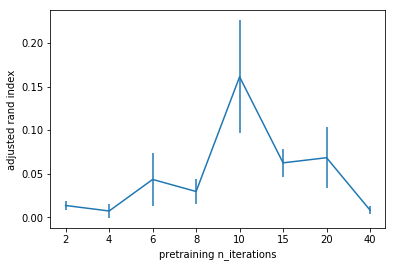

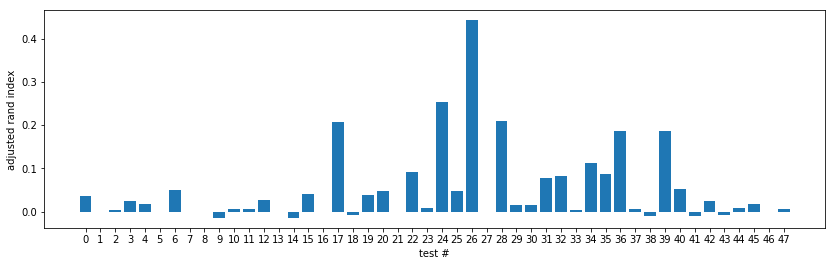

In [1131]:
t = res['tests_to_run']

x = [x[1][0] if x[1] else 0 for x in t]

#x[0] = 1
print x
rs = res['rs']
rs_all = rs

rs = np.array(rs).reshape(8,6)
x = sorted(list(set(x)))

r = np.mean(rs, axis=1)
e = np.std(rs, axis=1) / np.sqrt(6);

plt.errorbar(range(len(r)), r, e)
#plt.xscale('log')
plt.xticks(range(len(r)), x)
plt.xlabel('pretraining n_iterations')
plt.ylabel('adjusted rand index')
plt.show()


plt.figure(num=None, figsize=(14, 4))
plt.bar(range(len(rs_all)), rs_all)
plt.xticks(range(len(rs_all)), range(len(rs_all)))
plt.ylabel('adjusted rand index')
plt.xlabel('test #')
plt.show()

#for i in range(len(rs_all)):
#    print 'test_idx: ', i, ' rand index: ', rs_all[i]

# Running test #0: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 2, 2, 400


In [543]:
# Ensure reproducibility
#
np.random.seed(0)


In [544]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Sarah',

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', '

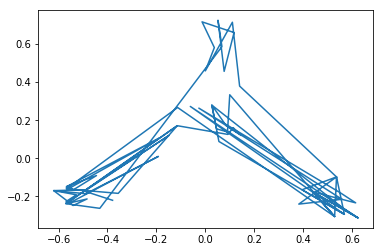

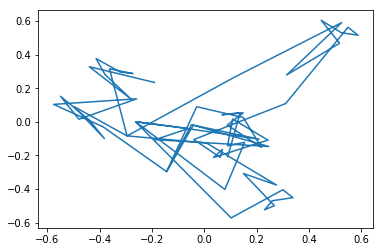

In [545]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [546]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [547]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [548]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [549]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_0_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_5XK1LG5U3B.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_4M4AKQOR9R.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.12143796  0.03074517 -0.02095167  0.02164034  0.02743825 -0.04512978
  0.01257843 -0.03046736 -0.01335922 -0.07240782 -0.02718181 -0.09793439
 -0.03532876  0.02793967 -0.03604849 -0.01356056 -0.03721297  0.01960493
 -0.07648408 -0.06339384 -0.01546038 -0.02966432 -0.05011907  0.00

In [550]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [551]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_0.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000006e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [552]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0602133994877
Adjusted Rand Score: 0.0354882224759

[1 1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


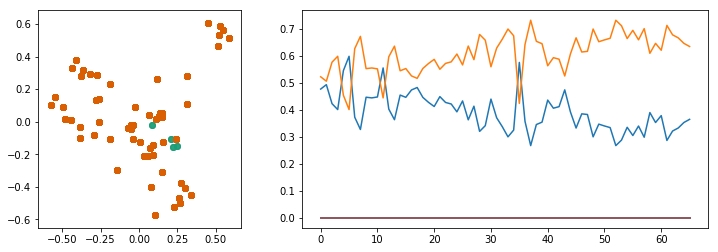

In [553]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


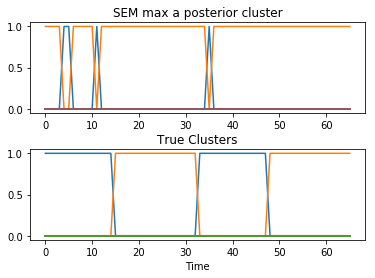

In [554]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #1: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 2, 2, 400


In [555]:
# Ensure reproducibility
#
np.random.seed(1)


In [556]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'ver

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 

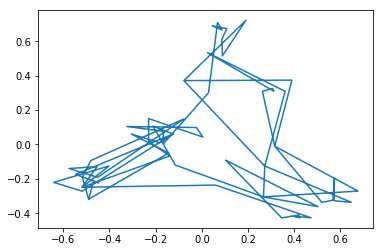

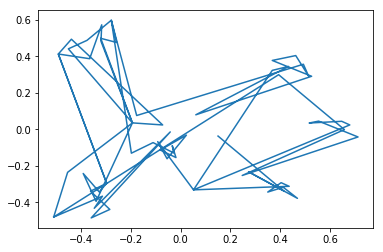

In [557]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [558]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [559]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [560]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [561]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_1_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_6LES9YXXEY.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_IDSHVGGVCO.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  2.63516832e-02  -1.01241518e-02  -5.45653948e-02  -5.47494000e-02
   2.02424867e-02   6.42588246e-02   1.13906356e-02  -2.22342589e-02
   4.11898399e-02   1.30461927e-02  -5.34575292e-02  -5.66387472e-03
   6.65618638e-04   7.60885738e-03  -1.34656053e-02   1.11573192e-01
   5.5558

In [562]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [563]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_1.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [564]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -1.75049310641e-15
Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


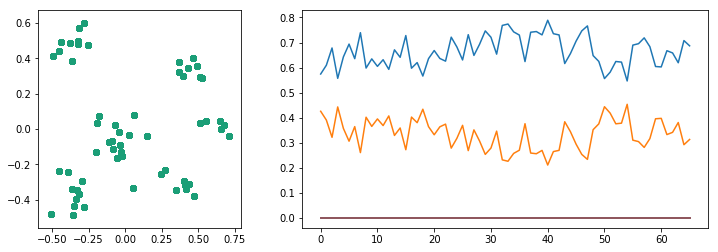

In [565]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


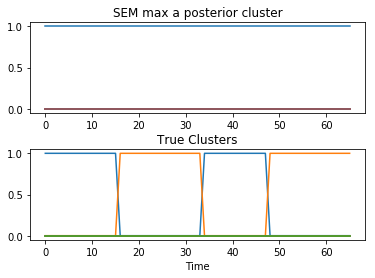

In [566]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #2: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 2, 2, 400


In [567]:
# Ensure reproducibility
#
np.random.seed(2)


In [568]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Sarah'

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_declines', 'verb'), ('Pradeep', 'Subject')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko',

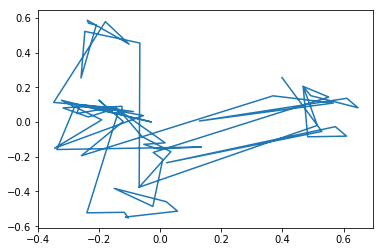

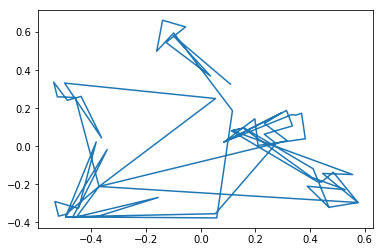

In [569]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [570]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [571]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [572]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [573]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_2_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_7YKOMLBEYN.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_6U35EFKZKZ.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -9.52861636e-02   3.61131540e-02   3.57911285e-03  -8.39136284e-02
   2.36852855e-02  -5.06991584e-02   8.81223000e-02  -6.12821599e-02
  -4.17139722e-02  -3.49192989e-02   6.69112961e-02  -1.61702356e-02
  -1.15611015e-01   7.08510955e-03   4.66424289e-02  -6.01767464e-02
   3.9360

In [574]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [575]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_2.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [576]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0013665127717
Adjusted Rand Score: 0.00367891267692

[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


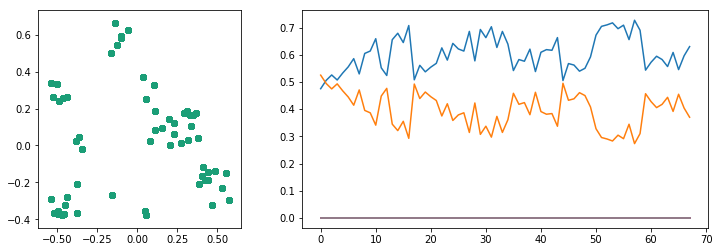

In [577]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


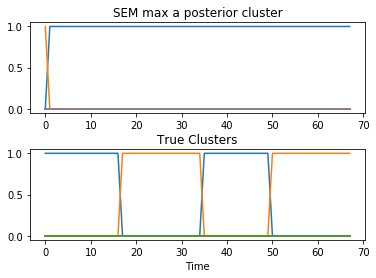

In [578]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #3: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 2, 2, 400


In [579]:
# Ensure reproducibility
#
np.random.seed(3)


In [580]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
##pretrain_data.plot_scenes()()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('EN

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Mariko', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 

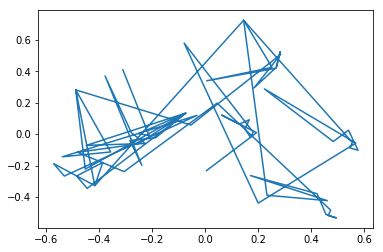

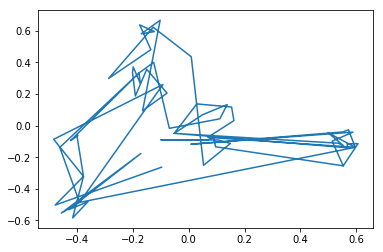

In [581]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [582]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [583]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [584]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [585]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_3_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_P7CY6C9WNA.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_5SG0U2FXWB.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  1.31828813e-01   6.36015047e-02   3.64429220e-02   3.50986477e-02
   1.03957193e-01  -5.25786836e-02   7.17951885e-03  -5.05168364e-02
   2.09680838e-02  -1.26472845e-01  -3.24777461e-02   3.98760786e-02
   2.70874966e-02  -8.81328105e-03  -7.73229897e-02  -1.25995770e-02
   1.6276

In [586]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [587]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_3.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [588]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0549194297399
Adjusted Rand Score: 0.0253056234719

[0 0 0 0 1 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


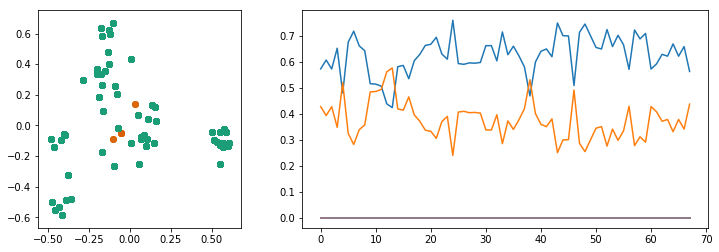

In [589]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


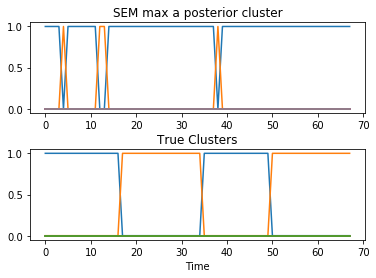

In [590]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #4: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 2, 2, 400


In [591]:
# Ensure reproducibility
#
np.random.seed(4)


In [592]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Jesse', 'Subject')], [('Walk_to_front', 'verb'), ('Jesse', 'Su

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('

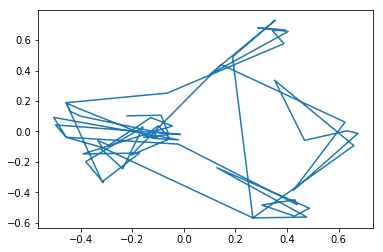

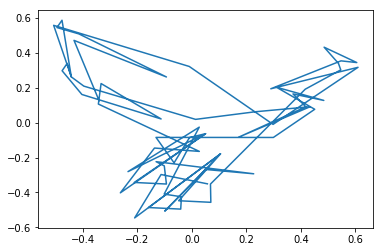

In [593]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [594]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [595]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [596]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [597]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_4_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_WGWX3N8C67.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_FNZL8DQYX7.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.09535604  0.00492576  0.01855359  0.06711    -0.00102949 -0.12715883
 -0.04353073 -0.03417461  0.03556749 -0.0273479   0.0648244  -0.02276589
 -0.03072125 -0.04184225 -0.06265943  0.00767524  0.078709    0.11026682
  0.05646048 -0.00257298  0.02280043  0.12395707 -0.00885468  0.03

In [598]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [599]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_4.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [600]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0218089067492
Adjusted Rand Score: 0.0167849797651

[0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


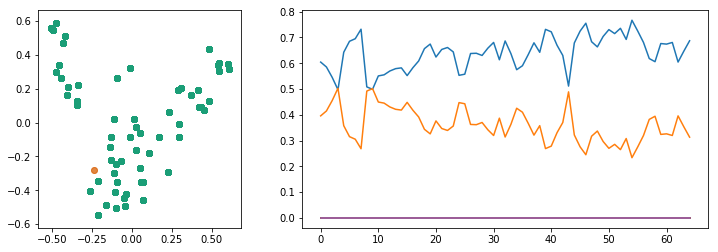

In [601]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


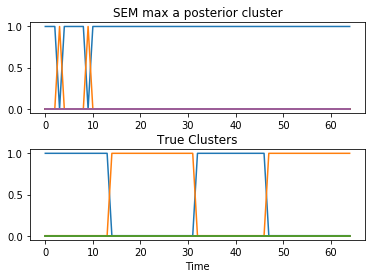

In [602]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #5: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 2, 2, 400


In [603]:
# Ensure reproducibility
#
np.random.seed(5)


In [604]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(2,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Ol

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('B

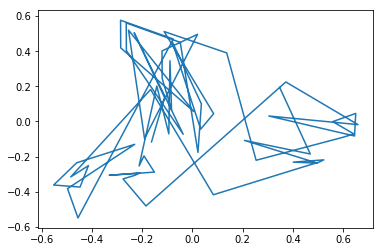

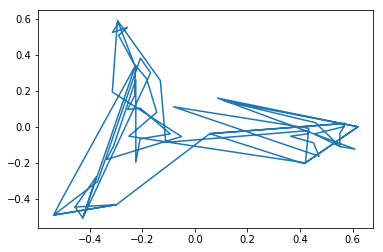

In [605]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [606]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [607]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [608]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [609]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_5_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_VNPNHEFPVO.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_FXPAYGW91S.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.02132035  0.11938468 -0.06088983  0.02310345  0.004866    0.02181974
  0.02083173  0.03880306  0.00376444  0.03148186 -0.05696994 -0.00790176
  0.00821727  0.07135123  0.02090978 -0.01990802 -0.02055489  0.03161612
 -0.03701772 -0.00097931  0.0024685  -0.09797001  0.01747056  0.07

In [610]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [611]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_5.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000001e+09   1.00000005e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [612]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.00876187826444
Adjusted Rand Score: 0.0

[1 1 1 0 0 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1
 1 0 1 1 1 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1]


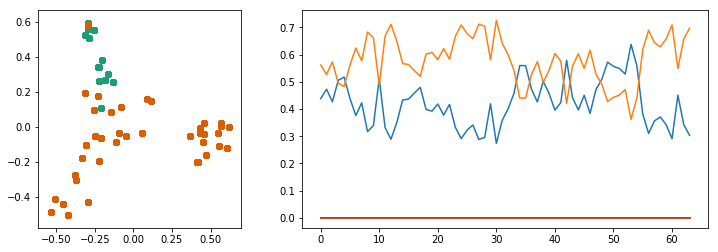

In [613]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


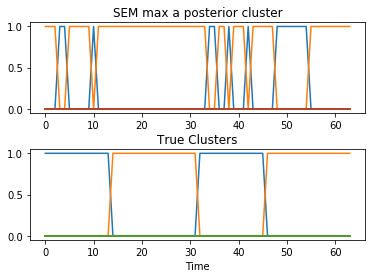

In [614]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #6: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 4, 2, 400


In [615]:
# Ensure reproducibility
#
np.random.seed(6)


In [616]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Walk_to_back', 'verb'), ('Oliv

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Olivia', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Olivia', 'Subject')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 

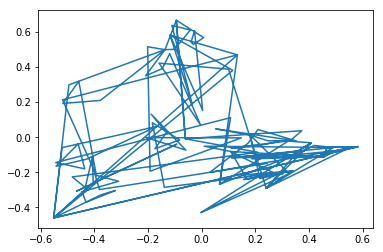

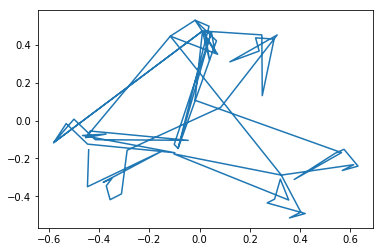

In [617]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [618]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [619]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [620]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [621]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_6_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_YE8008MABN.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_YZBWQ87FCW.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [-0.02231814  0.01608152  0.01029748 -0.02851834 -0.019291    0.02865128
  0.07177545  0.06466556  0.01510968  0.07576038  0.02786334  0.0093501
 -0.02287332  0.0317247  -0.00100944  0.06621547  0.09121863 -0.03850921
 -0.09735994 -0.02412158 -0.1136731  -0.02712182 -0.04857279  0.020

In [622]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [623]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_6.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [624]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0804075674591
Adjusted Rand Score: 0.0490479125442

[0 0 0 0 0 0 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


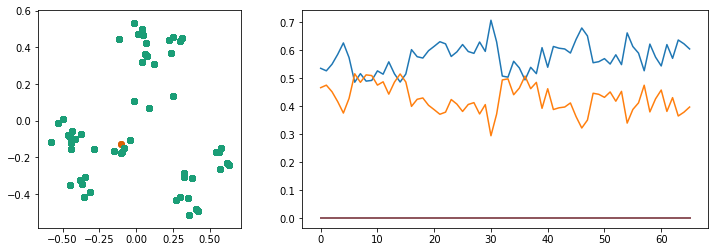

In [625]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


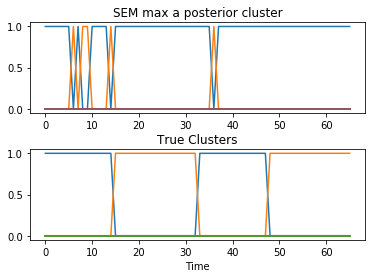

In [626]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #7: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 4, 2, 400


In [627]:
# Ensure reproducibility
#
np.random.seed(7)


In [628]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Ben', 'Subject')], [('Walk_to_back', 'verb'), ('Ben', 'Subject'), ('Silvia', 'Victim')], [('Step_in_front', 'verb'), ('Silvia', 'Victi

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Olivia', 'Subject')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Olivia', 'Subject')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Sarah', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pr

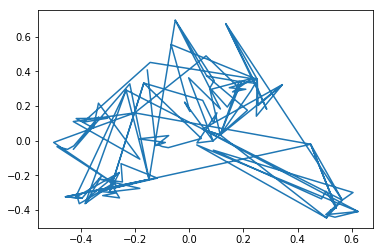

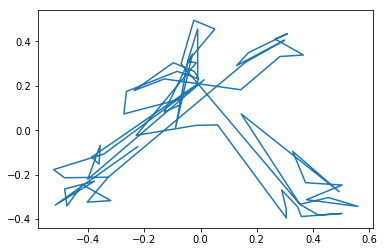

In [629]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [630]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [631]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [632]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [633]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_7_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_N9SZI369EK.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_VSZI9N0HE9.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.01769926  0.04141611 -0.02797689  0.03017616 -0.04054933  0.04381901
 -0.03840758  0.06638938 -0.06854241 -0.14412961 -0.00185944  0.01839218
 -0.06073513  0.04991758 -0.06698262 -0.07684445  0.06258669 -0.0714695
 -0.04506837  0.08340487 -0.03616684  0.03784284  0.07596476  0.049

In [634]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [635]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_7.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [636]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.0149641003406
Adjusted Rand Score: -0.00130951181766

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


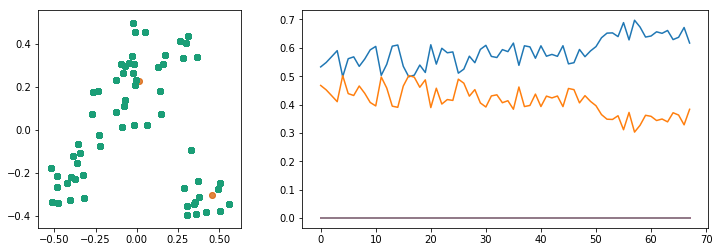

In [637]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


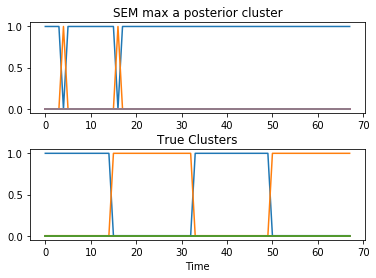

In [638]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #8: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 4, 2, 400


In [639]:
# Ensure reproducibility
#
np.random.seed(8)


In [640]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN'

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 

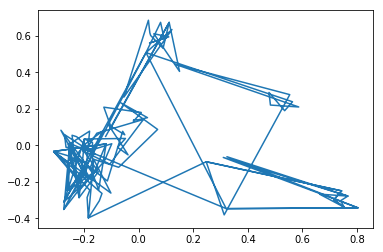

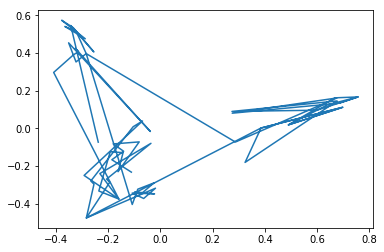

In [641]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [642]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [643]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [644]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [645]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_8_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_LFCTDPH3TN.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_TIN9JM3MIA.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  1.72141792e-02   2.81797005e-02  -7.05644966e-02   2.93826536e-02
   6.10586667e-02  -3.24578631e-02  -1.62041474e-02  -1.24367697e-02
  -3.32521294e-03  -9.84868107e-02  -3.88358358e-02   3.77443244e-02
  -1.40934163e-02   4.14689546e-02   4.76205575e-04   8.37751398e-02
   1.1569

In [646]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [647]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_8.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [648]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -1.75049310641e-15
Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


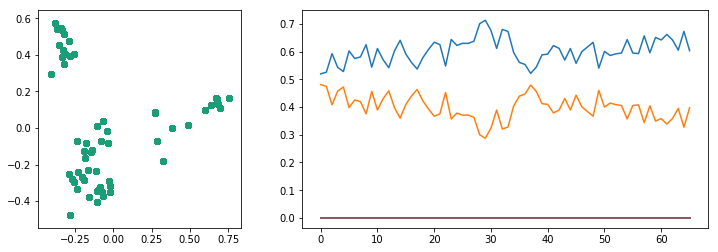

In [649]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


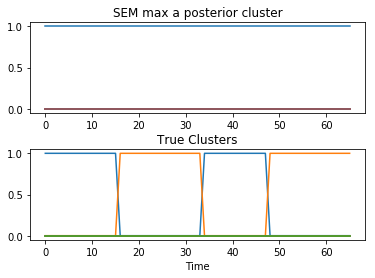

In [650]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #9: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 4, 2, 400


In [651]:
# Ensure reproducibility
#
np.random.seed(9)


In [652]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Order_dessert', 'verb'), ('Ju

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Prad

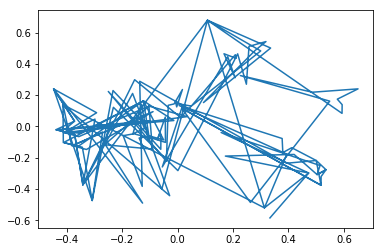

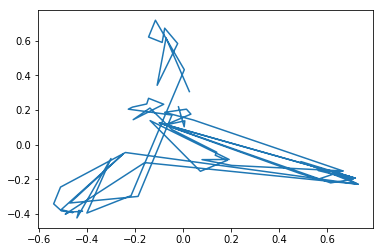

In [653]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [654]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [655]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [656]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [657]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_9_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_C50TSSV42Y.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_X1JJQDGVRR.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.13203071  0.07397563 -0.04546644  0.01474245 -0.01888488  0.01405734
 -0.01894167 -0.012521   -0.0374389   0.00484524 -0.02387896  0.06734701
 -0.06697193  0.01100261 -0.00114598  0.03060385  0.01828407  0.08027502
  0.0060506  -0.02137313 -0.02604169 -0.00394453 -0.03966192  0.05

In [658]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [659]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_9.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000004e+09   1.00000002e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [660]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.0100239424969
Adjusted Rand Score: -0.0141107273905

[1 0 1 1 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 1 0 0 0 1 0 0]


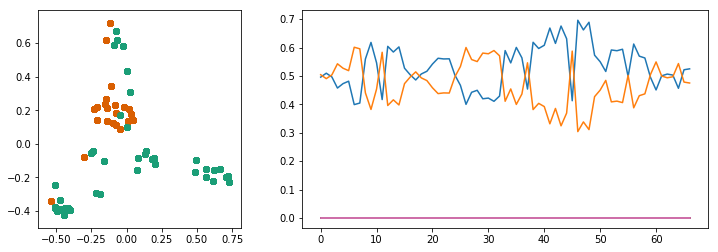

In [661]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


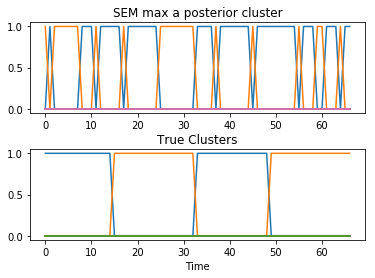

In [662]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #10: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 4, 2, 400


In [663]:
# Ensure reproducibility
#
np.random.seed(10)


In [664]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'E

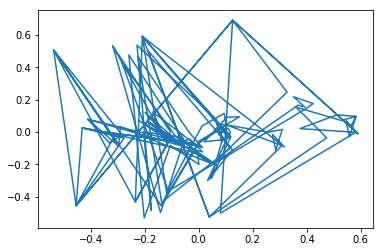

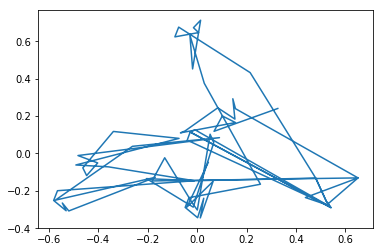

In [665]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [666]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [667]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [668]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [669]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_10_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_Y8XL8X3ERM.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_XRYMRMOFID.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  1.37338862e-02  -1.00893549e-02   6.86012948e-03  -4.99098587e-03
  -1.41046220e-03   8.03209938e-02  -2.12604476e-02  -2.05752555e-02
  -4.08924418e-02  -2.52777254e-02  -4.04559798e-03   4.73371974e-02
  -2.14695603e-02   8.77788170e-02  -3.92401261e-02  -3.84472153e-02
   2.2558

In [670]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [671]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_10.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [672]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0162797364947
Adjusted Rand Score: 0.00502528907609

[0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


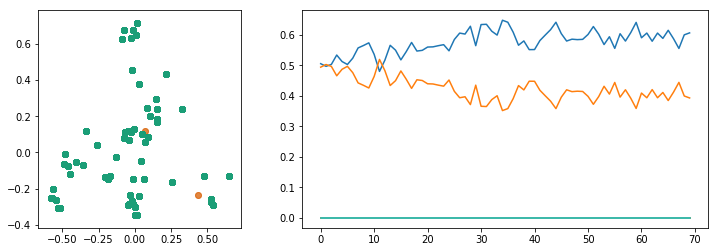

In [673]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


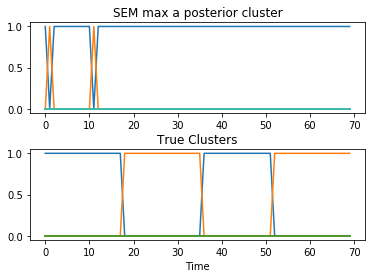

In [674]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #11: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 4, 2, 400


In [675]:
# Ensure reproducibility
#
np.random.seed(11)


In [676]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(4,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('END', 'verb'), ('Ju

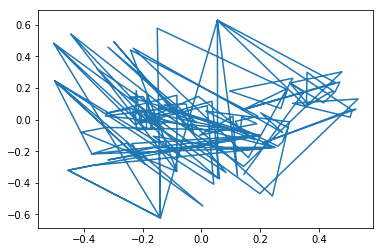

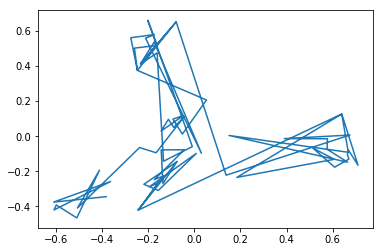

In [677]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [678]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [679]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [680]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [681]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_11_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_A3MX9W6YBL.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_LHB0ZYAZKQ.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  5.17874597e-03   4.71748067e-02   4.56726119e-03   6.34015473e-02
   6.55000303e-02  -3.29935500e-02  -4.08919616e-02   8.04529220e-02
  -3.02351167e-02  -2.98797472e-02   1.41703113e-02   3.54829647e-03
   6.74916015e-02   3.71563798e-02   3.14341591e-02  -4.44787656e-02
  -4.0454

In [682]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [683]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_11.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000007e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [684]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.00179061779406
Adjusted Rand Score: 0.00481734243276

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


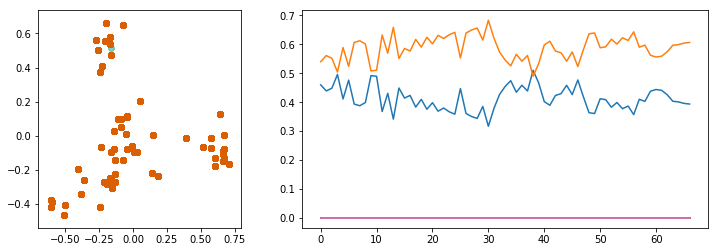

In [685]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


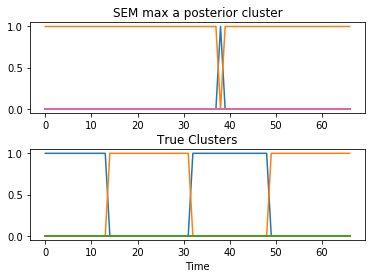

In [686]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #12: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 6, 2, 400


In [687]:
# Ensure reproducibility
#
np.random.seed(12)


In [688]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(6,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subjec

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mari

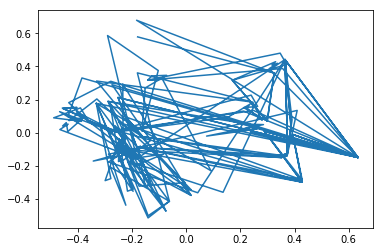

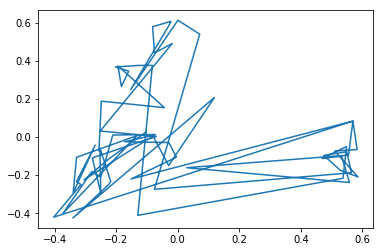

In [689]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [690]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [691]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [692]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [693]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_12_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_T17MUDXBU0.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_H26AOX9DXB.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  8.21977018e-03   1.35078580e-01   1.29106218e-02   2.04937991e-02
   1.24132424e-02   7.00230707e-03  -2.96411589e-02   3.20108178e-02
  -5.79906741e-02  -7.64349213e-02   4.35104472e-02   7.46011785e-03
   3.05424424e-02   9.05571615e-02  -4.98153740e-02   3.42267811e-02
   2.5852

In [694]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [695]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_12.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000001e+09   1.00000005e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [696]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.00998034088986
Adjusted Rand Score: 0.0266055249108

[0 1 1 1 1 0 1 0 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1
 0 1 1 0 1 1 1 0 1 1 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]


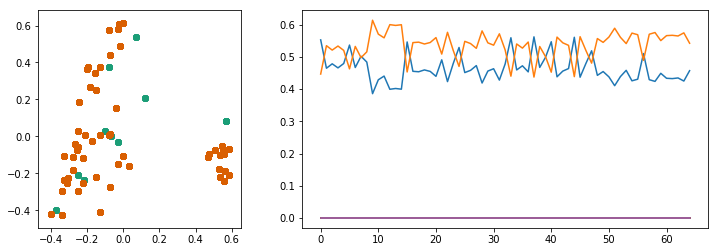

In [697]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


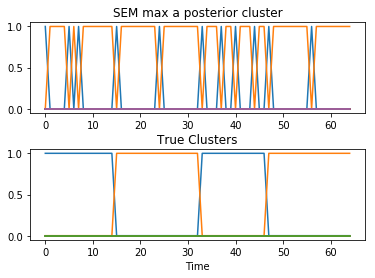

In [698]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #13: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 6, 2, 400


In [699]:
# Ensure reproducibility
#
np.random.seed(13)


In [700]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(6,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('P

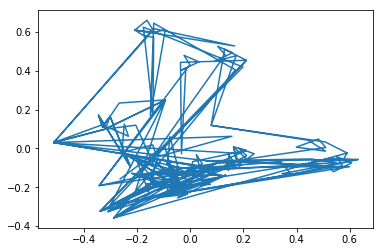

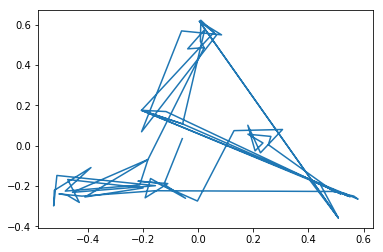

In [701]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [702]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [703]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [704]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [705]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_13_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_OVUGWJXNUY.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_632CTR53PA.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  2.98148494e-02  -3.56232670e-03   2.45728024e-02   3.68348023e-02
   4.81221328e-02  -1.54586705e-02  -5.31096356e-02   2.97978280e-02
  -4.50570131e-02   1.37764709e-01  -1.84372553e-02   2.53540201e-02
  -1.91770533e-02  -5.03373166e-02  -2.57966221e-02   3.75653801e-02
   5.2999

In [706]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [707]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_13.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [708]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 9.34446687276e-16
Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


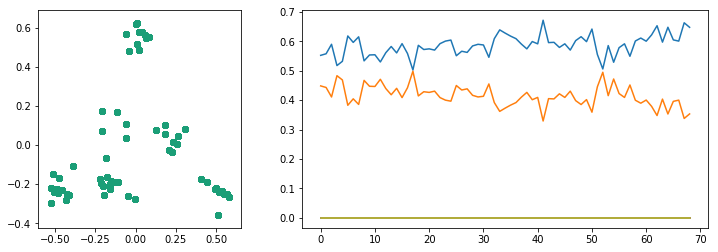

In [709]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


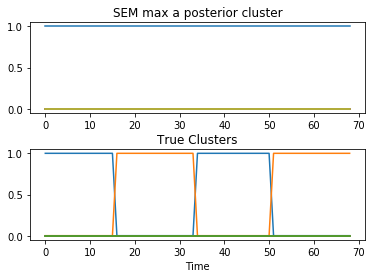

In [710]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #14: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 6, 2, 400


In [711]:
# Ensure reproducibility
#
np.random.seed(14)


In [712]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(6,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('J

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Olivia', 'Poet')], [('Po

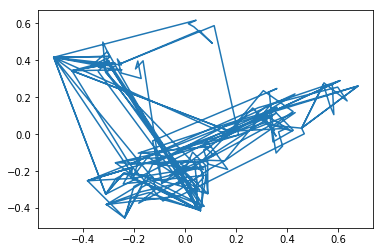

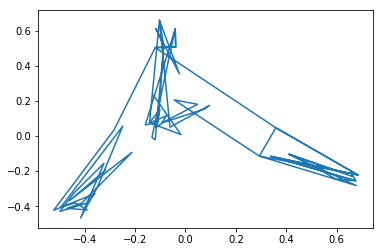

In [713]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [714]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [715]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [716]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [717]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_14_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_DD2ZQ42Z0F.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_QB1PRJZV88.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -4.41745491e-02  -1.78596387e-02  -4.17842836e-02  -2.25216906e-03
  -9.69530908e-03  -1.12296506e-01  -9.86832927e-02   3.42459807e-02
  -3.52898241e-02   8.28800429e-02   2.46538972e-04   1.54130293e-02
  -1.50252746e-02  -2.54093724e-02   3.91841156e-02   3.98613255e-02
  -2.1831

In [718]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [719]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_14.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000004e+09   1.00000002e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [720]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.0108033639991
Adjusted Rand Score: -0.0148320962392

[0 1 0 1 0 0 1 1 0 0 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1 1 1 1 1 0 1 1 0 0
 0 0 0 0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


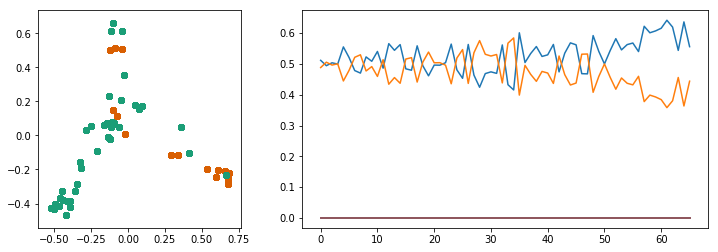

In [721]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


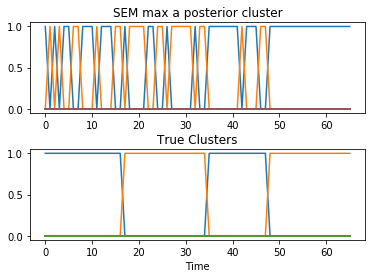

In [722]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #15: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 6, 2, 400


In [723]:
# Ensure reproducibility
#
np.random.seed(15)


In [724]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(6,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Jesse', 'Subject')], [('Walk_to_front', 'verb'), ('Jesse', 'Sub

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), 

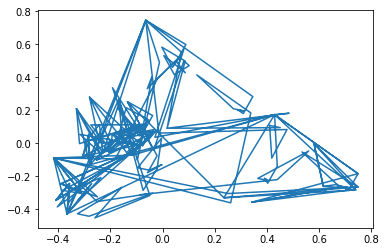

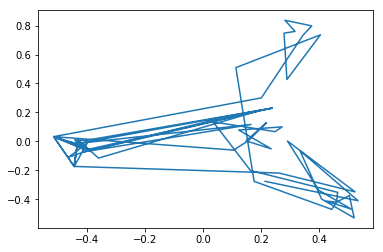

In [725]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [726]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [727]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [728]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [729]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_15_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_STF73DP86V.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_SBQ4W01A1H.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  2.25576066e-02   5.57542814e-03  -9.05678378e-03   3.65246108e-02
   9.41117403e-02  -3.34547932e-02  -8.49668646e-03  -4.73831354e-02
  -5.16722235e-02  -2.71531114e-02  -1.70286482e-02   6.01326095e-02
  -4.04174059e-02   1.59907853e-02   1.90360549e-02   5.94243791e-02
  -1.3017

In [730]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [731]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_15.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [732]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0885187144558
Adjusted Rand Score: 0.041554803315

[1 1 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


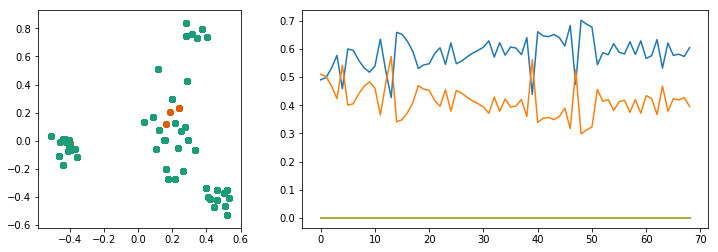

In [733]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


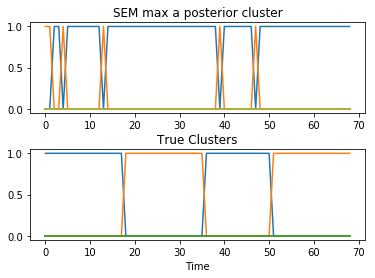

In [734]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #16: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 6, 2, 400


In [735]:
# Ensure reproducibility
#
np.random.seed(16)


In [736]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(6,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], 

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('W

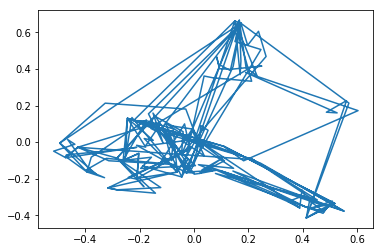

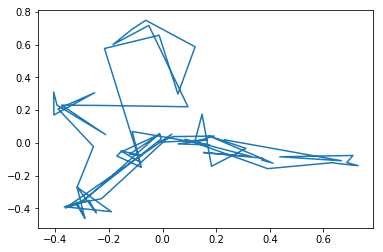

In [737]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [738]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [739]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [740]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [741]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_16_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_PO2LGU0F8G.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_L3GXS2UFUF.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.04595607 -0.08894434  0.03045841 -0.00288882 -0.01631812  0.04234556
 -0.046638   -0.00487617 -0.00523816  0.07256396 -0.05381913  0.02799014
  0.0402286  -0.0870603   0.02221704 -0.01308964 -0.04931391  0.00752375
 -0.00156194  0.08437113 -0.04660229 -0.00971895 -0.02379437 -0.03

In [742]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [743]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_16.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [744]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 1.1836767536e-15
Adjusted Rand Score: 0.0

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


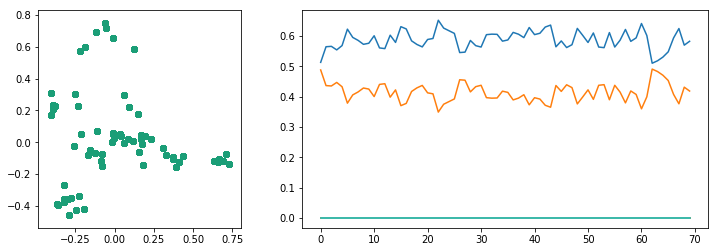

In [745]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


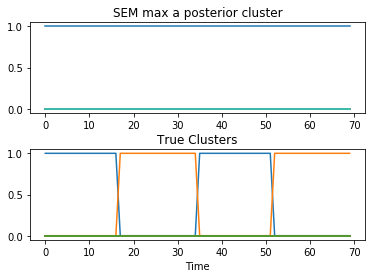

In [746]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #17: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 6, 2, 400


In [747]:
# Ensure reproducibility
#
np.random.seed(17)


In [748]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(6,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Olivia', 'Subject')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Jess

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('END', 

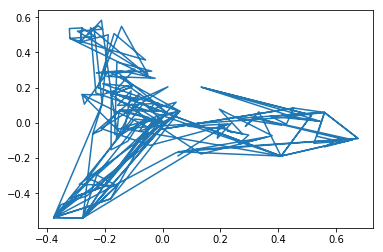

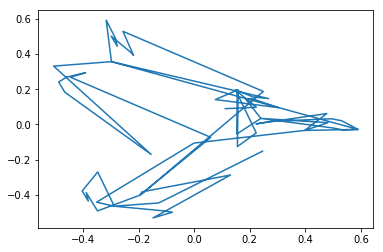

In [749]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [750]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [751]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [752]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [753]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_17_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_3ZB1FK2Q5Y.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_NSLO74RYZI.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.04858536  0.04091741 -0.10401719 -0.03688417  0.05381055  0.01982671
  0.12042674  0.06759488  0.00714344  0.03975969  0.00896233 -0.00241347
 -0.0384729  -0.08774859  0.04319242 -0.09052628  0.11413493  0.030593
  0.01300717 -0.00746438 -0.03552359  0.01240284  0.05201213  0.0773

In [754]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [755]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_17.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000001e+09   1.00000005e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [756]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.23258176363
Adjusted Rand Score: 0.207341269841

[1 1 1 1 0 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


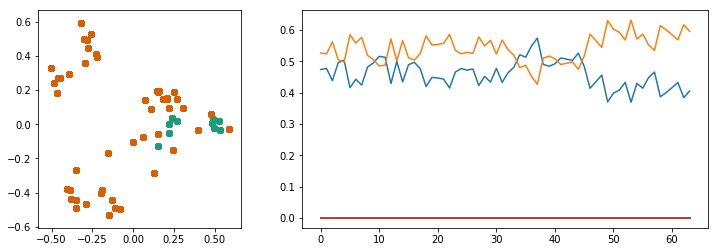

In [757]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


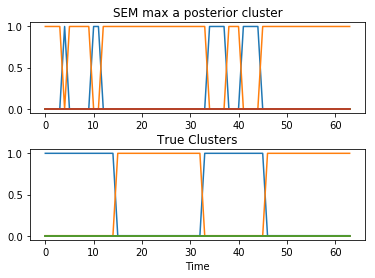

In [758]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #18: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 8, 2, 400


In [759]:
# Ensure reproducibility
#
np.random.seed(18)


In [760]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')]

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'ver

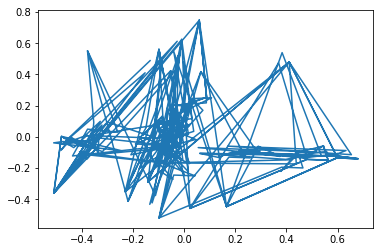

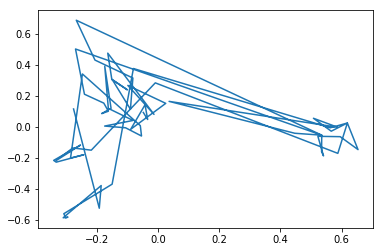

In [761]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [762]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [763]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [764]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [765]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_18_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_L324FBOWJB.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_D0DO4JQY04.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  9.79987974e-02   2.93555879e-02   8.22836820e-02   3.87047004e-02
   3.84402269e-02  -5.19325188e-02  -8.25978767e-02   5.83063771e-02
   6.52030020e-02  -8.72998216e-02   1.02355827e-02   2.19488330e-02
  -5.43673613e-02   1.06276678e-01  -2.02473548e-02   4.30064656e-02
  -2.9137

In [766]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [767]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_18.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000002e+09   1.00000005e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [768]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0109984365967
Adjusted Rand Score: -0.00694444444444

[1 0 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 0 1 0
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 0 0 0 1 0 1]


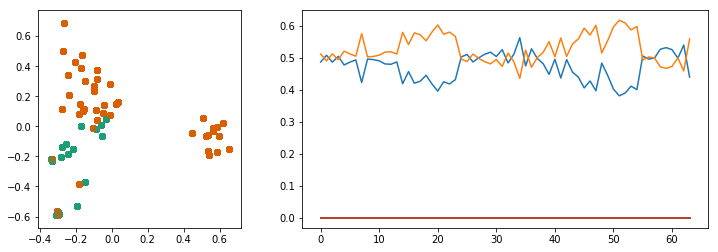

In [769]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


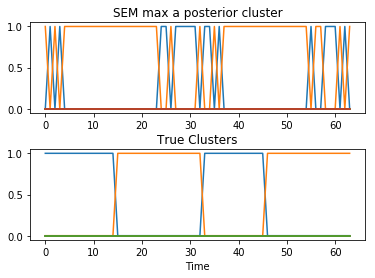

In [770]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #19: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 8, 2, 400


In [771]:
# Ensure reproducibility
#
np.random.seed(19)


In [772]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Will', 'Subject')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Nick', 'Subject')], [('Walk_to_back', 'verb'), ('Nick', 'Sub

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Olivia', 'Subject')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 

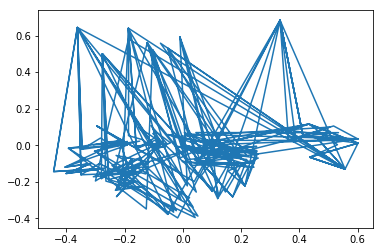

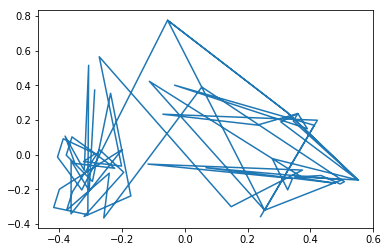

In [773]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [774]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [775]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [776]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [777]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_19_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_E1ZA41Y9VK.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_7G6PJTKIH9.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  7.27894266e-02  -8.30483955e-02   5.00271902e-02   1.64826577e-02
  -1.57475560e-03  -1.24292875e-02  -3.21256623e-02   4.52474547e-02
  -4.12350101e-02   4.44996179e-02   4.93923984e-02   5.42981057e-03
  -3.67440232e-02   2.27912679e-02   2.45931454e-02  -9.29965414e-02
  -6.8232

In [778]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [779]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_19.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [780]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0358575873353
Adjusted Rand Score: 0.0383744534666

[1 1 1 0 0 0 0 0 1 1 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


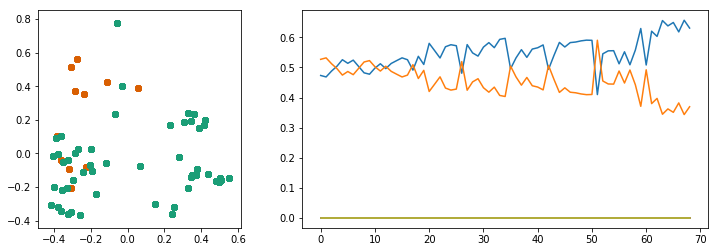

In [781]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


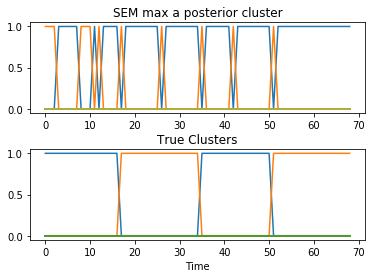

In [782]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #20: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 8, 2, 400


In [783]:
# Ensure reproducibility
#
np.random.seed(20)


In [784]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Sub

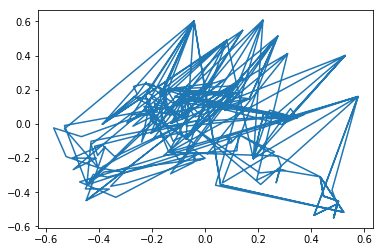

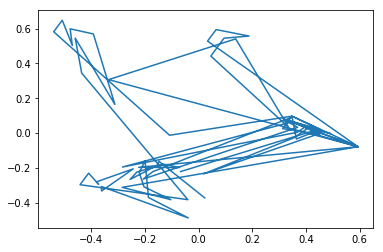

In [785]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [786]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [787]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [788]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [789]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_20_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_7FTAKQMMYA.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_MP3AHU311R.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  2.14572893e-03   1.22235292e-02   2.84703508e-02  -9.57387693e-02
   3.05972903e-02  -5.28909315e-02   6.73352479e-03  -5.13764973e-02
  -6.30187944e-02   4.70591127e-02  -7.76537353e-03  -1.58681787e-02
  -2.45963029e-03   4.42193813e-02   1.62724341e-02  -2.33068030e-02
  -3.1608

In [790]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [791]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_20.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [792]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0923554385381
Adjusted Rand Score: 0.0485767525541

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0
 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


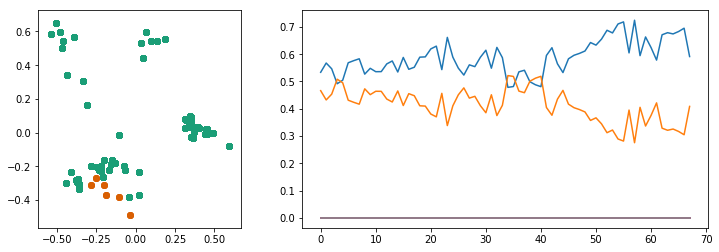

In [793]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


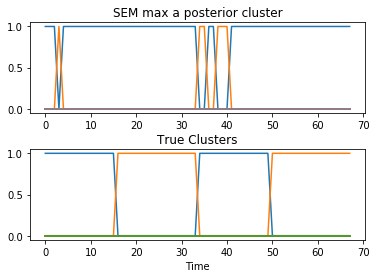

In [794]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #21: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 8, 2, 400


In [795]:
# Ensure reproducibility
#
np.random.seed(21)


In [796]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'v

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Sub

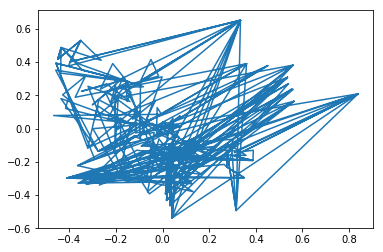

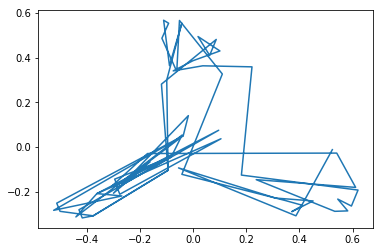

In [797]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [798]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [799]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [800]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [801]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_21_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_FVB9FO4BY8.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_L7E3TUQNWF.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.01287399 -0.07483866 -0.04230547  0.05089874  0.02109386  0.05656166
 -0.00554206  0.04449662  0.03566909 -0.04184049 -0.05674482 -0.0044138
  0.1012416   0.03097255  0.02180362 -0.00374094 -0.02161899 -0.04798987
  0.10077431  0.05947228 -0.05362373  0.00650433  0.01306913 -0.004

In [802]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [803]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_21.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [804]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.015516532034
Adjusted Rand Score: -0.000464406554767

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


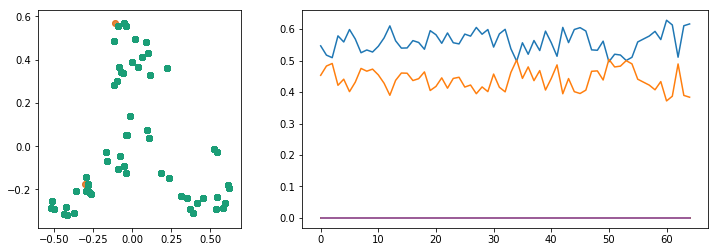

In [805]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


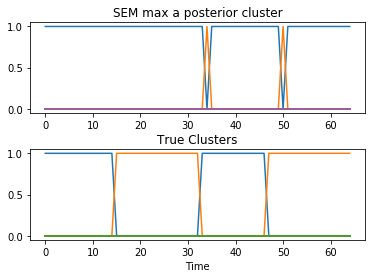

In [806]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #22: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 8, 2, 400


In [807]:
# Ensure reproducibility
#
np.random.seed(22)


In [808]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Will', 

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Will', 'Subject')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')]

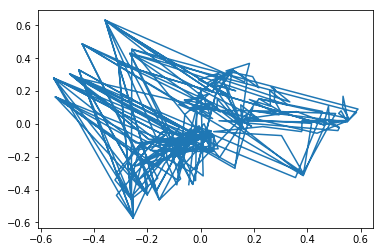

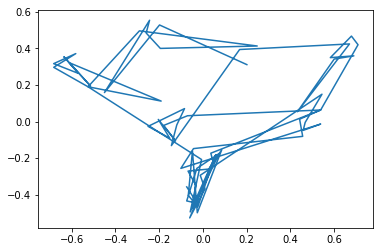

In [809]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [810]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [811]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [812]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [813]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_22_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_BGHV99YFQJ.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_HF6637O8HL.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.00854153  0.09727817 -0.10381682  0.02708948 -0.02173035  0.02510411
  0.06283634  0.08080314 -0.03934358 -0.04669973  0.00711574  0.0174681
 -0.03500676  0.08524824  0.01017355  0.04837661 -0.0307398  -0.05410915
  0.01762479 -0.05719267  0.00885173  0.03465702  0.0028499  -0.029

In [814]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [815]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_22.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [816]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.116191618302
Adjusted Rand Score: 0.0909760408484

[0 0 1 1 1 0 0 1 0 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


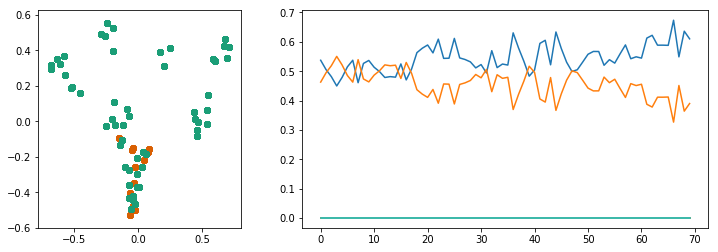

In [817]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


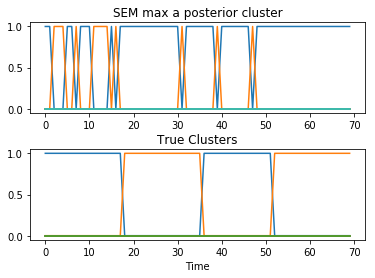

In [818]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #23: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 8, 2, 400


In [819]:
# Ensure reproducibility
#
np.random.seed(23)


In [820]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(8,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Olivia', 'Subject')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', '

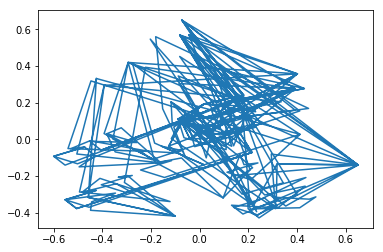

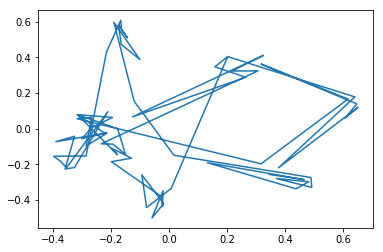

In [821]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [822]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [823]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [824]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [825]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_23_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_FKI75O8RSV.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_YWYBBGVR3V.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  2.86093958e-03   2.37813197e-02   9.49458042e-02  -1.22489620e-01
  -7.92295974e-02   9.83755323e-02   1.09853595e-02   1.69707483e-02
  -4.69966189e-02   5.58859916e-02   8.42575792e-03   5.44576253e-02
   1.89140192e-02  -3.50913103e-02  -6.73982405e-02   1.11032722e-01
   5.8852

In [826]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [827]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_23.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000007e+09   1.00000000e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [828]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0172250975022
Adjusted Rand Score: 0.00698519741806

[0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


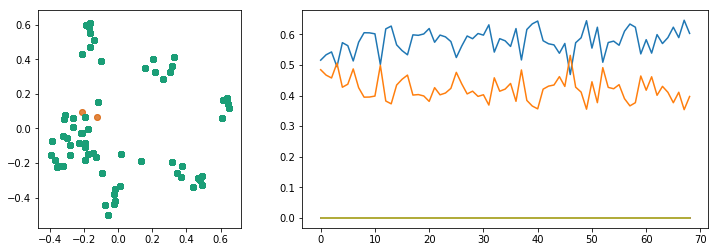

In [829]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


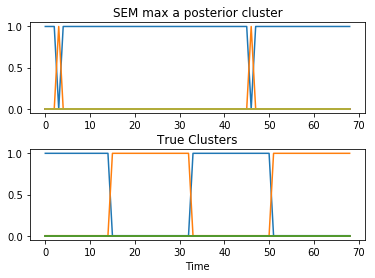

In [830]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #24: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 10, 2, 400


In [831]:
# Ensure reproducibility
#
np.random.seed(24)


In [832]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Sarah', 'Friend')], [('Order_dessert', 'verb'), ('Pradeep', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodb

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Olivia', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Olivia', 'Subject')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('mousse', 'Desse

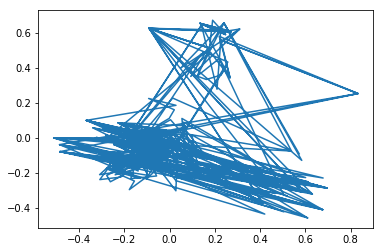

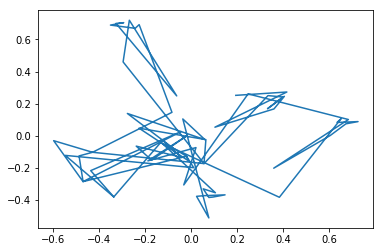

In [833]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [834]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [835]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [836]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [837]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_24_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_H0VE2N3JHC.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_9K65E8AHBC.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [-0.04498143  0.00350474  0.00699305 -0.08183072 -0.03784073 -0.05329847
 -0.12340836  0.03597192 -0.08041723  0.09082315  0.0586058  -0.01222483
 -0.01405204  0.00730882 -0.04710284  0.07693688 -0.08078376 -0.04537245
 -0.02401888  0.00305165 -0.05726525  0.00136428  0.01065017  0.03

In [838]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [839]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_24.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000002e+09   1.00000004e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [840]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.189673023172
Adjusted Rand Score: 0.254392825486

[0 0 1 0 0 0 1 1 1 0 1 0 1 0 0 1 1 1 1 1 1 0 1 0 1 1 1 1 1 1 1 1 0 1 1 0 1
 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 0]


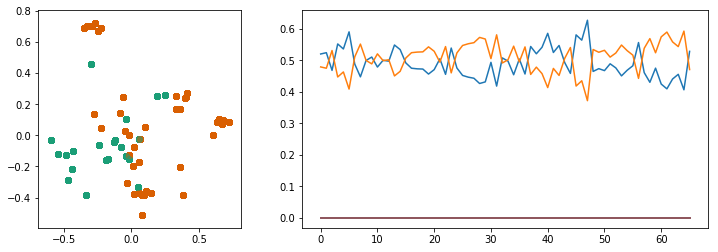

In [841]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


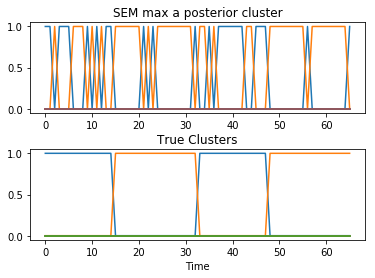

In [842]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #25: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 10, 2, 400


In [843]:
# Ensure reproducibility
#
np.random.seed(25)


In [844]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [(

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')]

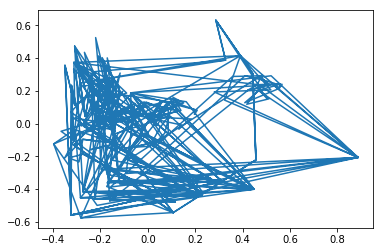

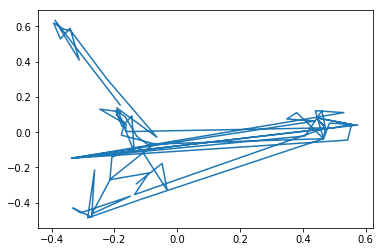

In [845]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [846]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [847]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [848]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [849]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_25_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_UHDW66U07R.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_QZBR3B3ISK.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  4.44274100e-02  -8.49951815e-02   5.43484968e-02  -7.03301932e-03
   9.71495061e-03   2.84836494e-02   1.24922056e-01  -3.92233877e-02
  -1.74014165e-02   2.34386464e-02   6.43179243e-02  -1.99530160e-02
   4.88795105e-02   4.86481740e-02   1.03706063e-02  -2.91805099e-02
   2.7400

In [850]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [851]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_25.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [852]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0461664968987
Adjusted Rand Score: 0.046604751845

[0 1 0 0 1 1 0 0 0 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]


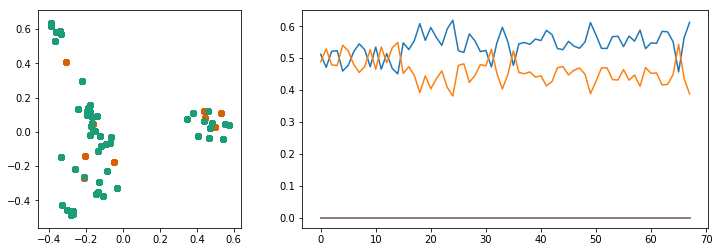

In [853]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


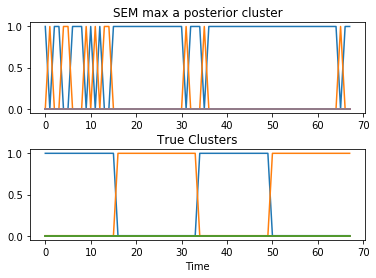

In [854]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #26: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 10, 2, 400


In [855]:
# Ensure reproducibility
#
np.random.seed(26)


In [856]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')

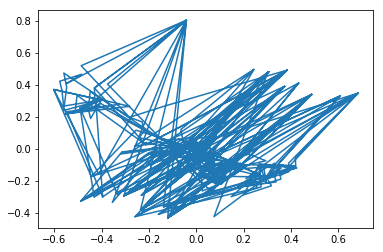

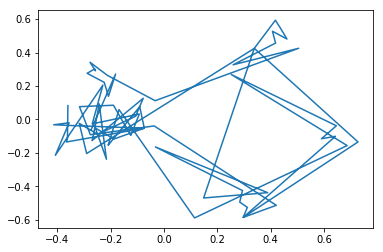

In [857]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [858]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [859]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [860]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [861]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_26_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_ZP7VY8CRQV.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_V2CLFUPY3Z.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -8.62841147e-03   1.11194602e-01  -5.29860802e-02   9.17886727e-02
  -8.46817650e-05   6.73920610e-03   5.39851233e-02  -7.74078945e-02
  -1.16515844e-01   4.52965442e-03  -3.42877034e-02   1.78424206e-02
   2.83669603e-02   1.53191992e-01   8.26413322e-03   2.54709664e-02
   2.7369

In [862]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [863]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_26.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000003e+09   1.00000004e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [864]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.34769355337
Adjusted Rand Score: 0.442716644653

[0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1]


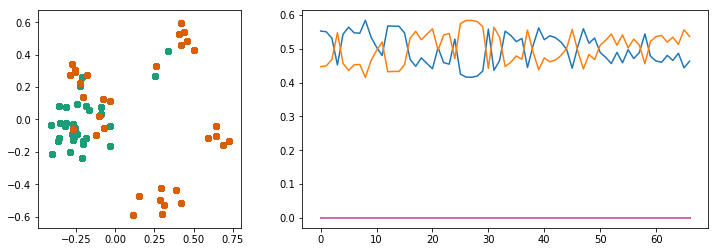

In [865]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


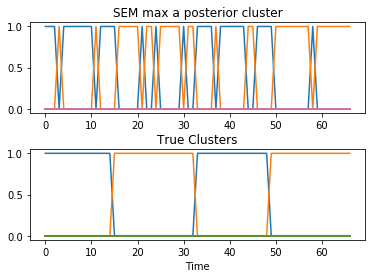

In [866]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #27: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 10, 2, 400


In [867]:
# Ensure reproducibility
#
np.random.seed(27)


In [868]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Sarah', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Say_goodb

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodby

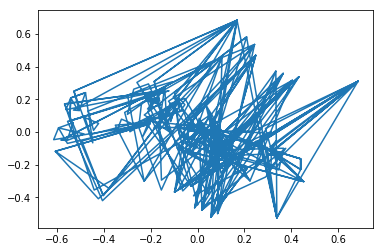

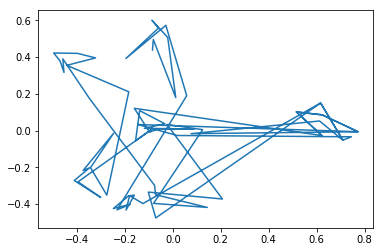

In [869]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [870]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [871]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [872]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [873]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_27_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_EANF294V9U.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_20TZY2JHNV.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [-0.07987608 -0.05263497 -0.0380662  -0.02268312 -0.00665621  0.03573506
  0.0054337  -0.00087793 -0.00046641 -0.05182036  0.0609712   0.0896389
  0.03340051 -0.00129015  0.03163579 -0.01046305  0.04757208 -0.0472692
 -0.03730265 -0.05290162  0.00652204 -0.07431687 -0.04806683  0.0443

In [874]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [875]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_27.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000003e+09   1.00000004e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [876]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.00133827737073
Adjusted Rand Score: -0.0013952210592

[0 1 0 0 1 1 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1
 1 1 1 1 1 1 0 1 0 0 0 1 0 0 1 0 1 1 1 1 1 1 1 1 0 0 1 0 0 1 1 0 0]


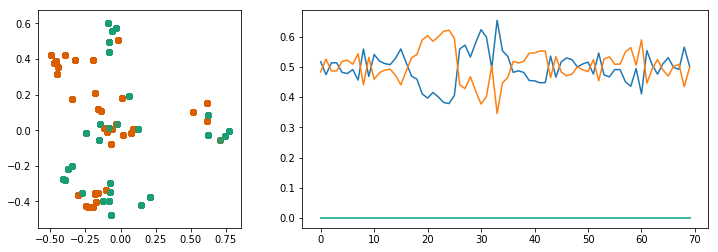

In [877]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


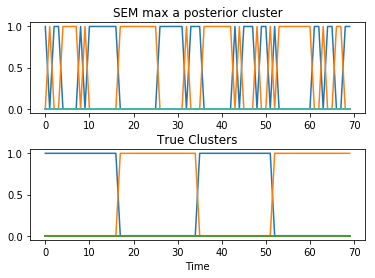

In [878]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #28: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 10, 2, 400


In [879]:
# Ensure reproducibility
#
np.random.seed(28)


In [880]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')]

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb')

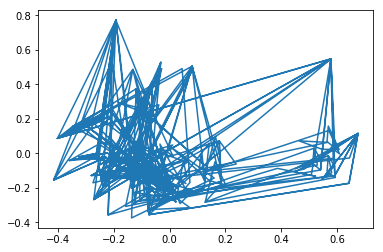

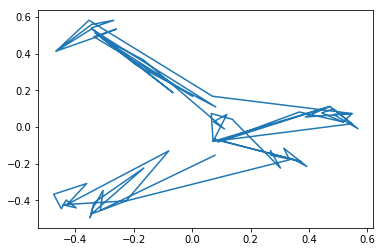

In [881]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [882]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [883]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [884]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [885]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_28_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_BZIS9EK5QD.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_IMG0TATBUL.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -6.20793856e-02   1.53694598e-02  -5.79411542e-02  -3.59970310e-02
   7.70475045e-02  -2.96379136e-02  -8.71524837e-03  -1.65885456e-02
   1.28474700e-02  -2.94113352e-03  -1.43368252e-02  -2.69037477e-02
  -2.13862490e-02   1.48767903e-02   4.46950804e-03   1.07747355e-02
  -6.7487

In [886]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [887]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_28.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000003e+09   1.00000004e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [888]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.154963434782
Adjusted Rand Score: 0.209825268942

[0 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 1 0 1 1 1
 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 0 1 1 1 1 0 0]


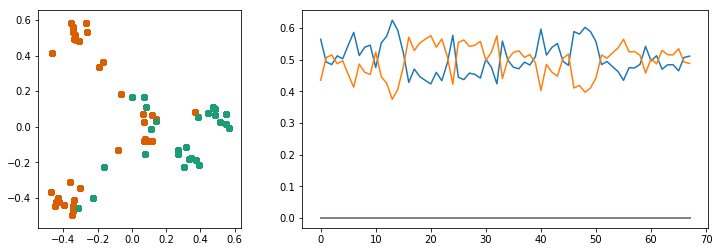

In [889]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


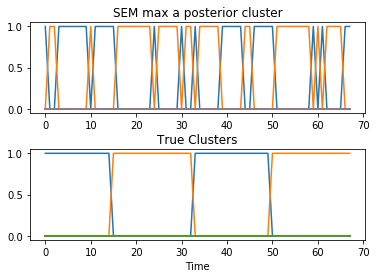

In [890]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #29: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 10, 2, 400


In [891]:
# Ensure reproducibility
#
np.random.seed(29)


In [892]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(10,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'S

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Order_dessert', 'verb'), ('Julian', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Olivia', 'Subject')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('O

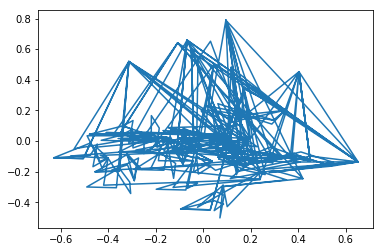

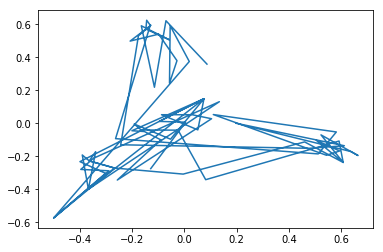

In [893]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [894]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [895]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [896]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [897]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_29_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_GNPTM2E8SG.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_J4GL24E9XB.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [-0.0645094  -0.06269878 -0.02950938  0.03129733  0.07093809 -0.03855823
 -0.00574554  0.01400718  0.06914318  0.0388647  -0.02635921  0.00014456
  0.02438527  0.091641    0.01217222 -0.04691772  0.00080176 -0.01533121
  0.11087791 -0.00530701 -0.0035319  -0.05676961  0.02902494  0.00

In [898]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [899]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_29.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [900]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0770902574032
Adjusted Rand Score: 0.0153868734558

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


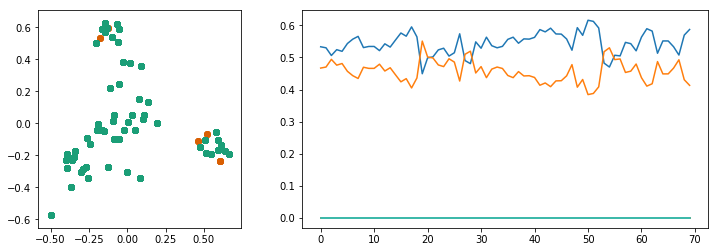

In [901]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


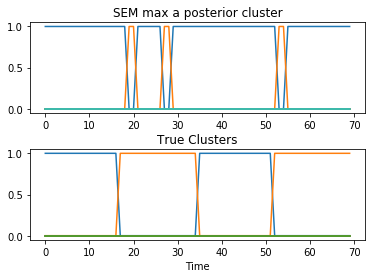

In [902]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #30: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 15, 2, 400


In [903]:
# Ensure reproducibility
#
np.random.seed(30)


In [904]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(15,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Order_dessert', 'verb'), ('Mariko', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Pradeep', 'Subject')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mar

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Vera', 'Subject')], [('Walk_to_front', 'verb'), ('Ver

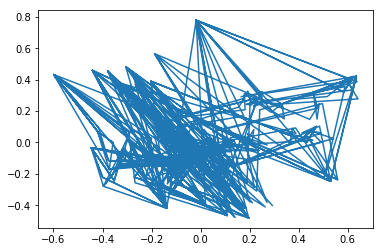

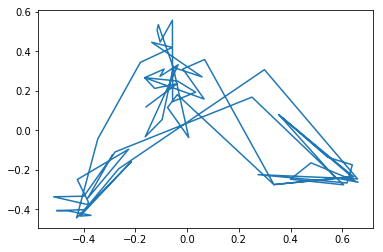

In [905]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)

print test_data.X[0,0:10]
print res['test_data'].X[0,0:10]
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [906]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [907]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [908]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [909]:
print test_data.y.shape
print pretrain_data.y.shape

(65,)
(501,)


In [910]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_30_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_J8443MBT9V.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_VXWZZ24QPE.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.08072606  0.01891659 -0.09103066 -0.03408843  0.05892874 -0.02588062
 -0.04304799 -0.03452307 -0.03115996 -0.02536332  0.12870187  0.01350121
 -0.07844628 -0.01081341  0.008047   -0.0622441  -0.01247959  0.09083269
  0.09332157 -0.10157126  0.04880905  0.02545785  0.00225786  0.05

In [911]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)

print res['pretrain_data'].X[0,0:10]
print pretrain_data.X[0,0:10]

[-0.01447163  0.10183709  0.04734327 -0.09556333 -0.03753199 -0.01817804
  0.01133713  0.00031391 -0.02808254 -0.00413363]
[-0.01447163  0.10183709  0.04734327 -0.09556333 -0.03753199 -0.01817804
  0.01133713  0.00031391 -0.02808254 -0.00413363]


In [912]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_30.pkl')
sem.deserialize(res['sem'])
post = res['post']
test_data = res['test_data']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [913]:
print res['test_data'].X[0, 0:10]
print test_data.X[0,0:10]

[ 0.00399863 -0.09687528 -0.00400918  0.03729153  0.05539977  0.00137076
 -0.01693037 -0.07474488  0.01596908  0.03116107]
[ 0.00399863 -0.09687528 -0.00400918  0.03729153  0.05539977  0.00137076
 -0.01693037 -0.07474488  0.01596908  0.03116107]


In [914]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0010758273264
Adjusted Rand Score: 0.0155876361704

[0 0 0 0 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


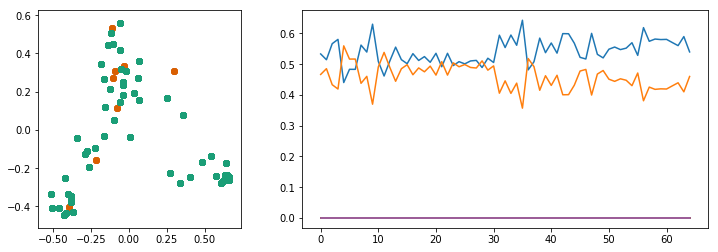

In [915]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


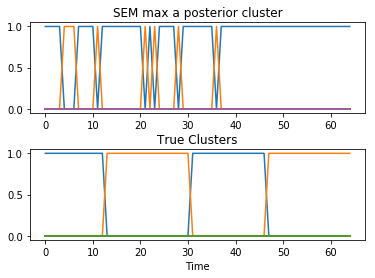

In [916]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #31: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 15, 2, 400


In [917]:
# Ensure reproducibility
#
np.random.seed(31)


In [918]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(15,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), (

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Olivia', 'Subject')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('

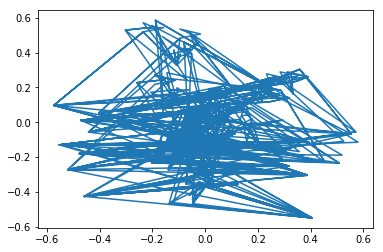

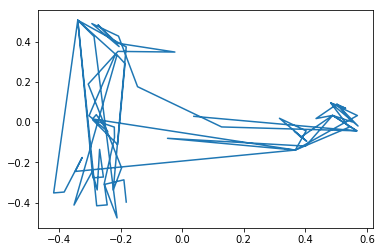

In [919]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [920]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [921]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [922]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [923]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_31_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_4VDER3R2PW.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_3WAKCDGCTO.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -3.66747810e-02  -3.28336275e-02   4.63812599e-02  -4.74232738e-02
  -1.08834321e-01   2.51955306e-02   1.45101009e-01  -8.38341506e-03
  -9.18231295e-02  -2.80359020e-02  -4.84145223e-02   2.55477754e-02
  -1.80366184e-02   2.45325905e-02   7.68652656e-03  -9.39817648e-02
   2.2114

In [924]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [925]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_31.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000002e+09   1.00000005e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [926]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0675730941434
Adjusted Rand Score: 0.0767752148349

[1 1 1 1 0 0 1 1 1 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 1 1 1 1 0 1 1 0 0 1 1 0 0
 0 1 1 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


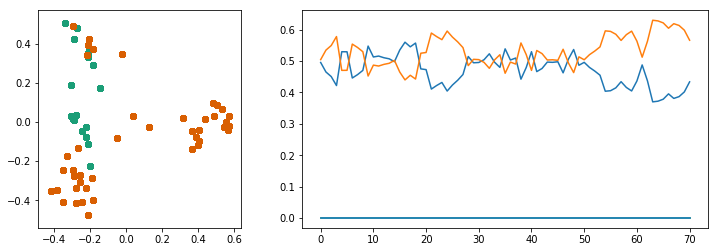

In [927]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


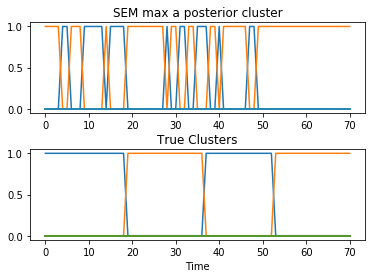

In [928]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #32: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 15, 2, 400


In [929]:
# Ensure reproducibility
#
np.random.seed(32)


In [930]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(15,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Mar

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject')

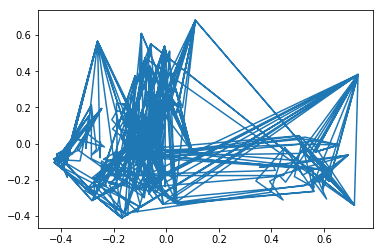

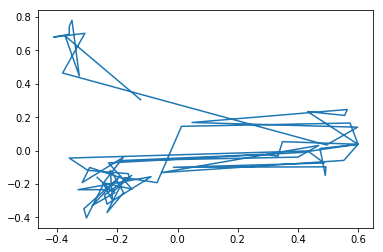

In [931]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [932]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [933]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [934]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [935]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_32_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_EW6LLAVKGE.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_VYL8JTPNWO.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -4.96896735e-02   6.94717694e-02  -4.34412533e-04  -3.86983905e-02
  -1.97122503e-03  -1.50377249e-02  -3.64422952e-02   5.93261084e-02
  -1.44631641e-01  -1.50556180e-02  -4.51964056e-02   1.86317099e-02
  -9.53637951e-02  -5.12267975e-02   2.44180672e-02  -6.62452353e-02
   5.8327

In [936]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [937]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_32.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000001e+09   1.00000006e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [938]:
# Evaluate performance
# 
test_data = res['test_data']

y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.08425908185
Adjusted Rand Score: 0.0812073255504

[1 0 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0
 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1]


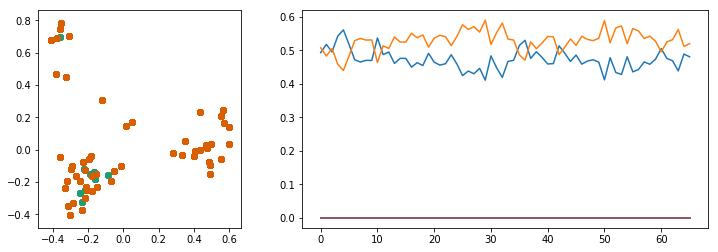

In [939]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


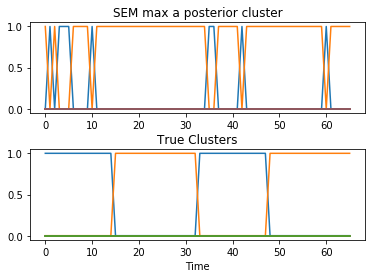

In [940]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #33: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 15, 2, 400


In [941]:
# Ensure reproducibility
#
np.random.seed(33)


In [942]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(15,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_declines', 'verb'), ('Julian', 'Subject')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Sarah', 

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'),

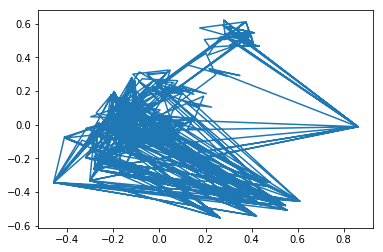

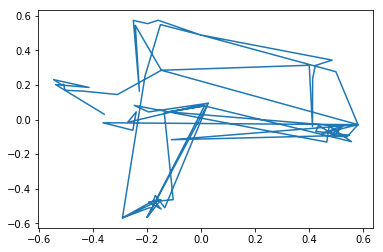

In [943]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [944]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [945]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [946]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [947]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_33_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_W7NOML7AX8.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_8YYI7B480U.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.00191113  0.0070819  -0.00587325  0.00759954 -0.03722466  0.0944261
 -0.01250041 -0.00532552 -0.11323524  0.01121149 -0.0773012  -0.0055203
 -0.00232121  0.00230122  0.10052102 -0.00335054  0.01336233  0.04037142
  0.09311809  0.01973845 -0.08960073  0.0681796  -0.00557909  0.0967

In [948]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [949]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_33.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000005e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [950]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0156362013836
Adjusted Rand Score: 0.00294862934808

[0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 1 1 1 1 1 1 1 0 0
 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]


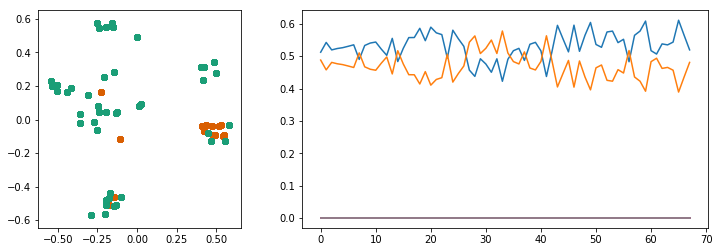

In [951]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


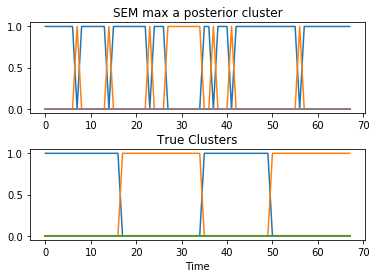

In [952]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #34: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 15, 2, 400


In [953]:
# Ensure reproducibility
#
np.random.seed(34)


In [954]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(15,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Olivia', 'Subject')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Will', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subjec

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 've

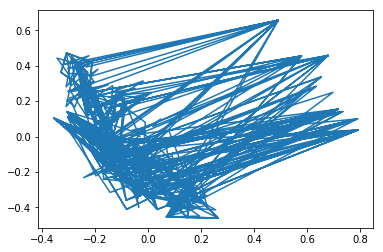

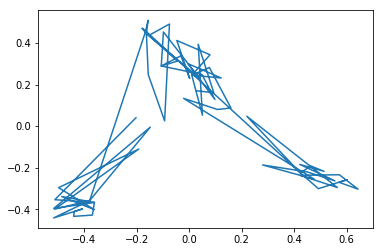

In [955]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [956]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [957]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [958]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [959]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_34_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_VUY8T4Z62Y.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_YVBTOF2SGL.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -7.43692841e-02  -1.30664029e-02  -7.69550592e-02  -4.17532020e-02
  -5.96431938e-03   5.29583165e-02   2.60703834e-02  -4.61169494e-03
   4.74195526e-02   3.80378145e-02  -7.09850054e-02  -7.76872519e-02
  -1.97168458e-02  -4.92694221e-02  -6.11763586e-02  -2.17109367e-02
   2.7426

In [960]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [961]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_34.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000004e+09   1.00000003e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [962]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0795359983306
Adjusted Rand Score: 0.1116704481

[1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 1 1 1 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 0 1 0 0 0 1 1 0 1 0 1 0]


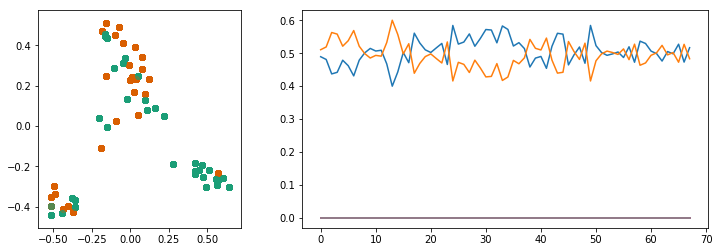

In [963]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


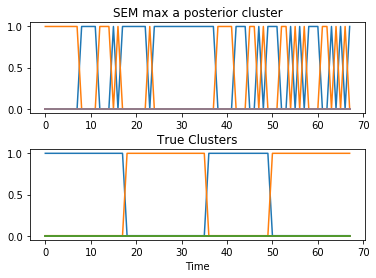

In [964]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #35: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 15, 2, 400


In [965]:
# Ensure reproducibility
#
np.random.seed(35)


In [966]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(15,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Olivia', 'Friend')]

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'E

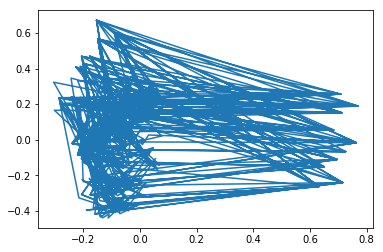

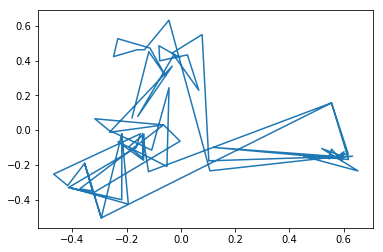

In [967]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [968]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [969]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [970]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [971]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_35_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_Z4BQVDX3HP.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_QY00G3ZA5F.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  4.50188667e-02   1.31267103e-02  -5.47679004e-02   1.57529568e-01
  -1.44929325e-03  -6.87635472e-02   7.87718823e-02  -3.05111094e-02
  -5.60855066e-02  -3.80009602e-02   4.50308377e-02   1.67858936e-02
   1.05635239e-01  -2.09241292e-02   3.05429409e-02  -4.39598822e-02
   6.8600

In [972]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [973]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_35.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000002e+09   1.00000005e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [974]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0769886367303
Adjusted Rand Score: 0.0867838910947

[1 1 1 0 0 1 1 1 1 1 1 1 1 0 0 1 1 1 1 1 0 1 1 0 1 0 1 1 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 1 1 0 1 1 1 1 1 0 1 0 1 1 0 1 1 1 1 1 0 1 1 0 0 0 1 1]


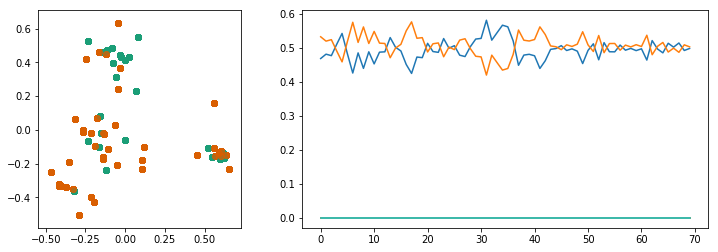

In [975]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


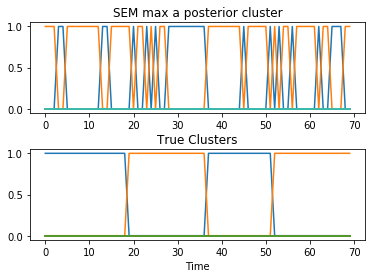

In [976]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #36: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 20, 2, 400


In [977]:
# Ensure reproducibility
#
np.random.seed(36)


In [978]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(20,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Po

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Walk_to_back', 'verb'), ('Olivia'

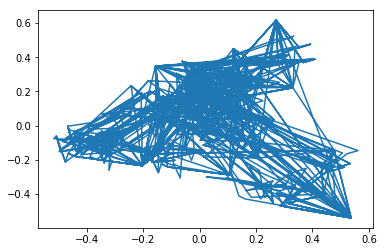

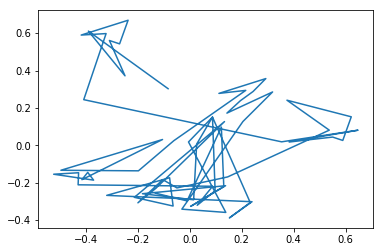

In [979]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [980]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [981]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [982]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [983]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_36_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_PZQMG16N3F.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_SRYHJO5K35.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  1.19934268e-01   2.33348740e-02   8.86219187e-02   1.15549333e-03
   2.96661081e-02  -5.58502830e-03  -3.01333561e-02   9.27022433e-02
  -3.54122986e-02  -3.08276863e-03  -3.60897138e-02   2.94901900e-02
  -7.18549746e-02  -6.99911021e-02  -5.17694806e-02  -9.63983491e-02
  -7.7122

In [984]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [985]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_36.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000003e+09   1.00000004e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [986]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.170760935688
Adjusted Rand Score: 0.186616671474

[1 1 1 1 1 1 1 1 1 1 0 1 0 1 0 1 1 1 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 0 1 1 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0]


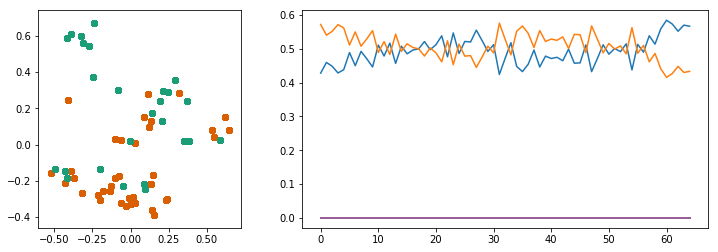

In [987]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


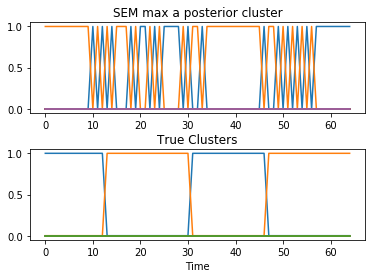

In [988]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #37: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 20, 2, 400


In [989]:
# Ensure reproducibility
#
np.random.seed(37)


In [990]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(20,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')]

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Sar

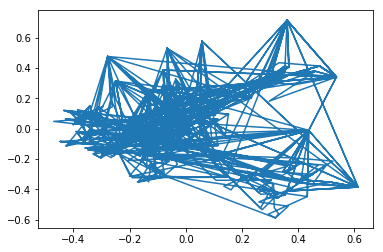

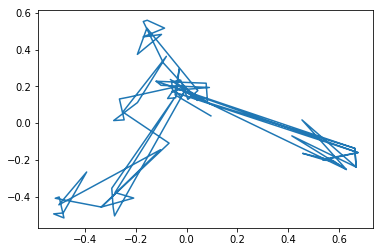

In [991]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [992]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [993]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [994]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [995]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_37_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_TRNRC3WEZL.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_F7I5NPYHSZ.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [-0.01516904 -0.0814242  -0.0389106  -0.02476469 -0.02387659 -0.05786546
 -0.00542755  0.01209619  0.01249996 -0.01884232  0.00100253 -0.04852576
 -0.08910964 -0.05291958  0.02468923 -0.02198963  0.01638297 -0.1155302
  0.02636524 -0.01202026  0.04038457 -0.03375299  0.05886358  0.057

In [996]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [997]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_37.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000001e+09   1.00000006e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [998]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.00317442976569
Adjusted Rand Score: 0.0061637058209

[0 1 1 1 1 1 0 0 0 1 1 1 1 1 1 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 0]


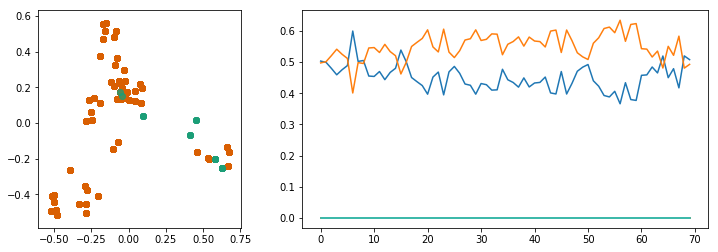

In [999]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


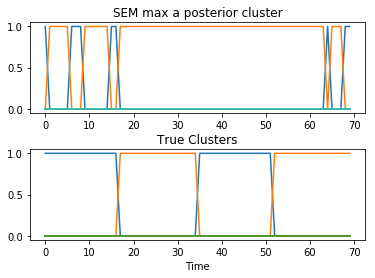

In [1000]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #38: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 20, 2, 400


In [1001]:
# Ensure reproducibility
#
np.random.seed(38)


In [1002]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(20,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Pradeep', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Pradeep', 'Friend')], [('END', 'ver

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('J

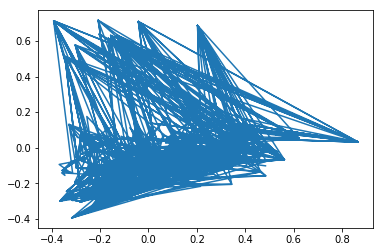

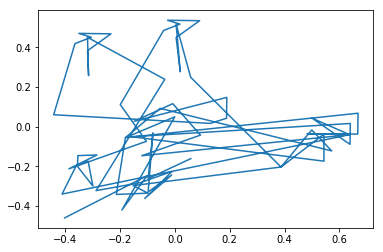

In [1003]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1004]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1005]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1006]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1007]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_38_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_VHRBPEOY66.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_S13OS75JC6.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -5.14234645e-02  -1.39173468e-02   9.30447679e-02  -3.46532670e-03
  -7.08758762e-03  -5.01657369e-02  -3.03442556e-02   1.13543633e-02
  -5.14104915e-02   1.19940189e-02   2.44340750e-02  -9.39924036e-02
  -1.25264641e-02   2.50145453e-03  -3.85002863e-02   3.19631321e-02
  -1.0788

In [1008]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1009]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_38.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000004e+09   1.00000003e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1010]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.00923130026791
Adjusted Rand Score: -0.0112209918864

[1 1 1 0 0 1 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0
 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 0 1 1 0 0]


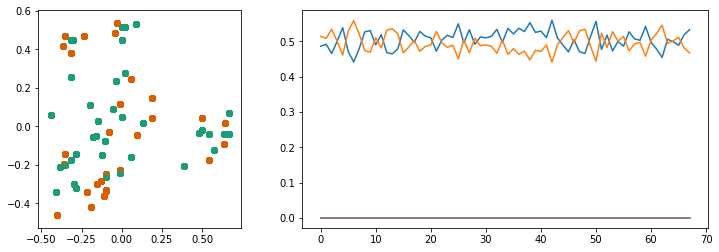

In [1011]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


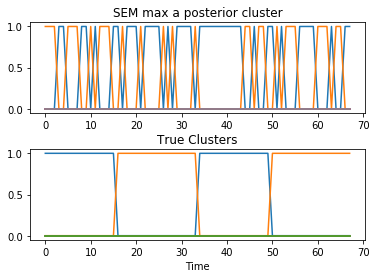

In [1012]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #39: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 20, 2, 400


In [1013]:
# Ensure reproducibility
#
np.random.seed(39)


In [1014]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(20,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Nick', 'Subject')], [('Walk_to_back', 'ver

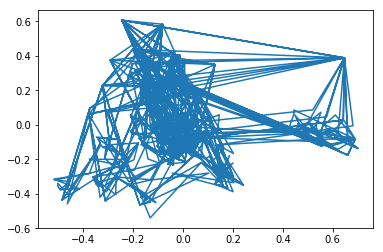

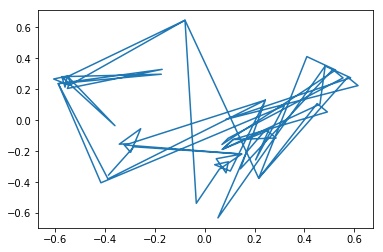

In [1015]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1016]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1017]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1018]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1019]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_39_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_M93CRQCS5E.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_DD957NAZQI.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ 0.03672594 -0.0497923   0.02428383 -0.07644829 -0.00053838 -0.09590039
  0.04964983  0.02588383  0.08638769  0.00417476  0.01828901 -0.03735407
 -0.01181561 -0.04337429  0.06666616  0.02830134  0.09625345 -0.00308661
  0.03726247  0.03475289  0.01985367 -0.13151349  0.04321039  0.07

In [1020]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1021]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_39.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000004e+09   1.00000002e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1022]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.185579979927
Adjusted Rand Score: 0.186706895022

[0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 1 0 1 1 0 1 1 1 0 1 0 1 1]


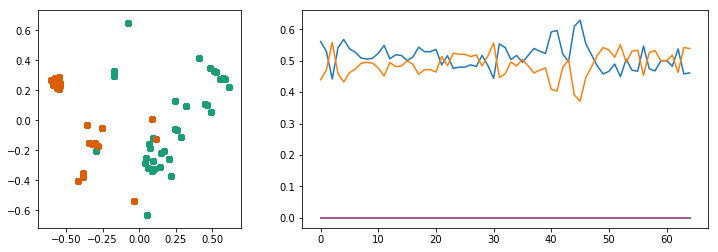

In [1023]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


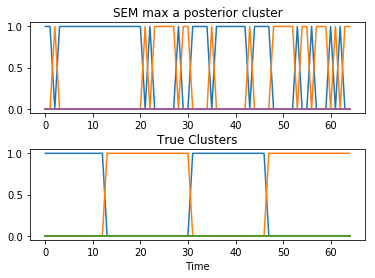

In [1024]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #40: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 20, 2, 400


In [1025]:
# Ensure reproducibility
#
np.random.seed(40)


In [1026]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(20,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Mariko', 'Subject')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Will', 'Friend')], 

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye'

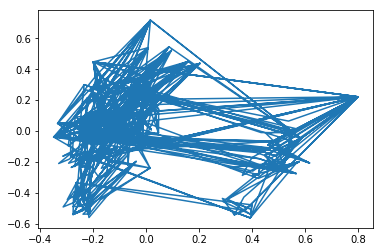

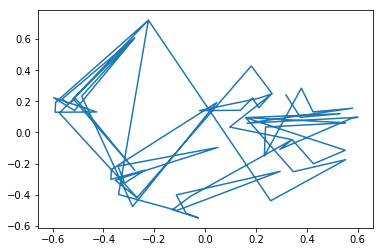

In [1027]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1028]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1029]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1030]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1031]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_40_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_EN8Q5FECWN.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_WGK333HLA1.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  3.10594326e-02   3.32934965e-02   3.35952529e-02  -1.17322725e-02
  -1.25963503e-02  -2.04156462e-02   2.45590703e-02  -9.37513811e-02
  -3.44600762e-02  -4.47353252e-02  -6.35020046e-02   3.47983685e-02
   6.58634286e-02  -1.74562771e-02  -6.42499919e-02  -5.22832957e-02
   8.0712

In [1032]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1033]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_40.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000005e+09   1.00000002e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1034]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0359395454436
Adjusted Rand Score: 0.0525600528906

[0 1 1 0 1 1 0 1 0 0 0 0 1 1 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


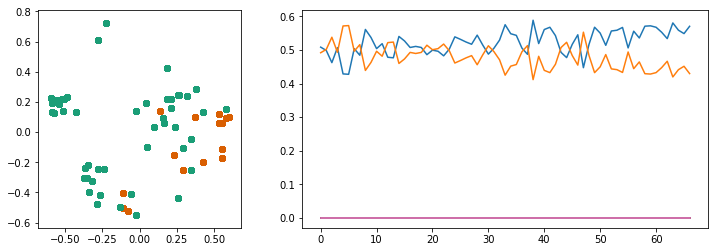

In [1035]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


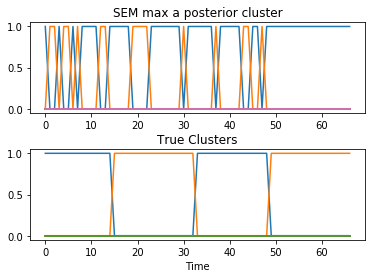

In [1036]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #41: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 20, 2, 400


In [1037]:
# Ensure reproducibility
#
np.random.seed(41)


In [1038]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(20,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_perform

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Pradeep', 'Friend')], [('END', 'verb'), ('Julian', 'Su

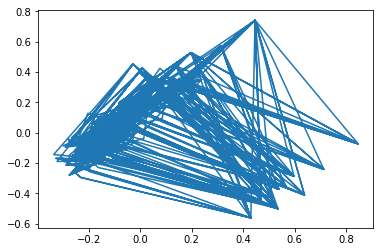

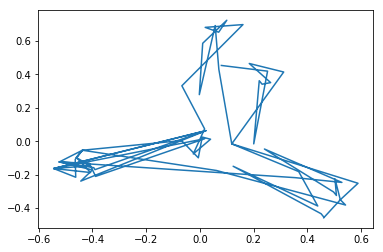

In [1039]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1040]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1041]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1042]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1043]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_41_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_NTJG5WN6BW.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_0WM3JDF443.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -2.81694606e-03   5.41237483e-03  -4.72393769e-02  -4.35654915e-02
  -3.38330784e-02   4.84786263e-02  -4.10085669e-02   4.36691907e-02
   1.27457989e-02   4.68161760e-02  -2.40306811e-02  -3.52766939e-02
   1.10403875e-01  -3.84746213e-02   6.77699384e-02   6.79365152e-04
  -9.3001

In [1044]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1045]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_41.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000002e+09   1.00000005e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1046]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.0110320153182
Adjusted Rand Score: -0.0104723635108

[1 1 0 0 0 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 0 0
 1 1 1 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 0 1 1]


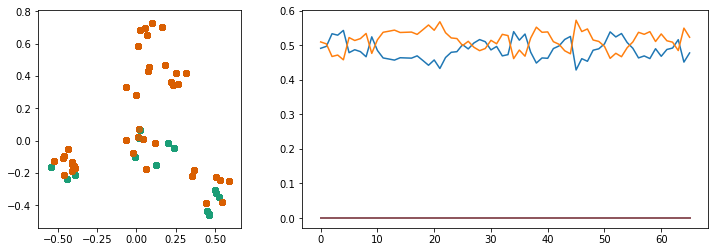

In [1047]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


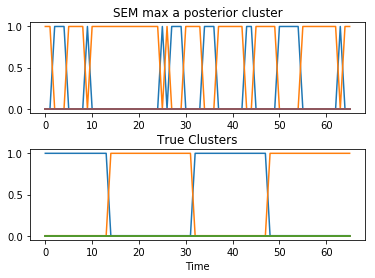

In [1048]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #42: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 40, 2, 400


In [1049]:
# Ensure reproducibility
#
np.random.seed(42)


In [1050]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Pradeep

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Sar

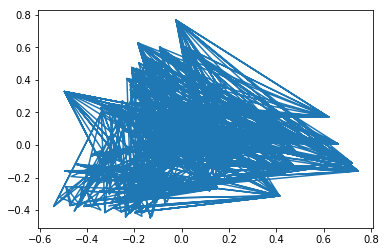

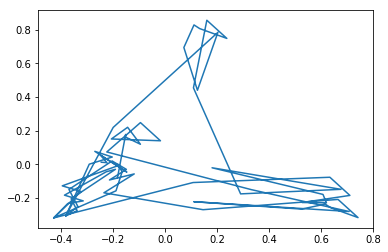

In [1051]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1052]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1053]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1054]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1055]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_42_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_3L44JIW8CA.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_BOCZGLJVTF.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  3.83823515e-02  -9.02367749e-02   2.68069985e-02  -4.01255991e-02
  -6.11744970e-02   3.93098895e-02  -1.70712681e-02   1.47976834e-02
  -8.70187627e-03   1.17316419e-01  -1.99267409e-02   3.05683612e-02
   4.10725993e-02   8.87420180e-02  -8.10490398e-02   3.28448449e-02
  -1.0556

In [1056]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1057]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_42.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000005e+09   1.00000002e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1058]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0124205278843
Adjusted Rand Score: 0.024453617547

[0 1 0 1 0 0 0 1 1 1 1 1 1 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1]


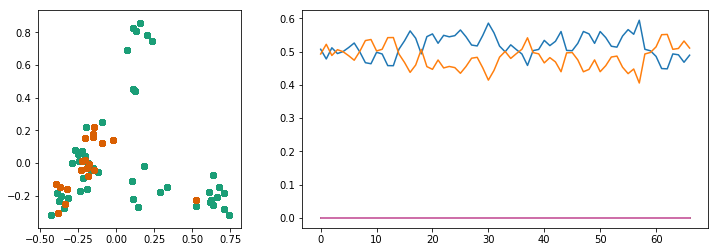

In [1059]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


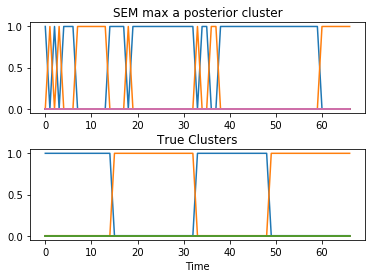

In [1060]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #43: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 40, 2, 400


In [1061]:
# Ensure reproducibility
#
np.random.seed(43)


In [1062]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Mariko', 'Subject')], [('Order_drink', 'verb'), ('Mariko', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Will', 'Poet')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_declines', 'verb'), ('Mariko', 'Subject')], [('Say_goodbye', 'verb'), ('Mariko', 'Subject'), ('Sarah', 'Friend')], [('END', 'verb'), ('Mariko', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Julian', 'Poet')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subje

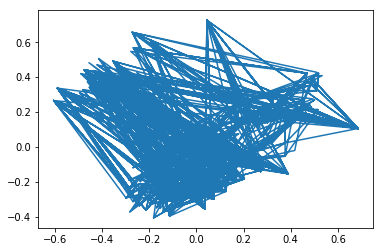

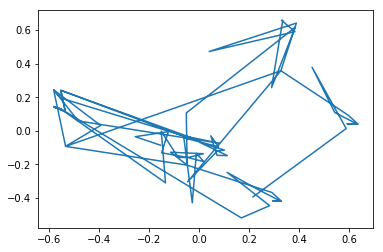

In [1063]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1064]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1065]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1066]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1067]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_43_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_07B7Q49SKE.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_MQDV6E4HLP.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [-0.02515406 -0.07092532  0.02466893  0.05598632  0.02807295  0.11121288
  0.0095592  -0.05558531 -0.09549526  0.06947631 -0.016612    0.02367269
  0.02473675 -0.07258197  0.01256651  0.01397776 -0.01656303  0.01190953
 -0.02584058  0.0133213  -0.04588479 -0.0589871  -0.01604571  0.02

In [1068]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1069]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_43.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1070]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.00729130792583
Adjusted Rand Score: -0.00697299964507

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0]


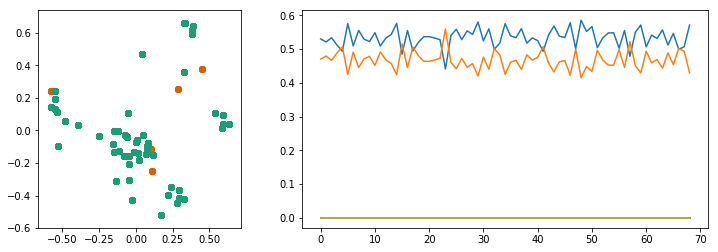

In [1071]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


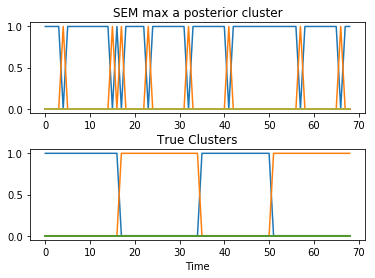

In [1072]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #44: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 40, 2, 400


In [1073]:
# Ensure reproducibility
#
np.random.seed(44)


In [1074]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Order_dessert', 'verb'), ('Sarah', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Sarah', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Pradeep', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'),

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Julian', 'Subject')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('Say_goodbye', 'verb'), ('Julian', 'Subject'), ('Will', 'Friend')], [('END', 'verb'), ('Julian', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_performs', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('END', 'verb'), ('Sarah', 'Sub

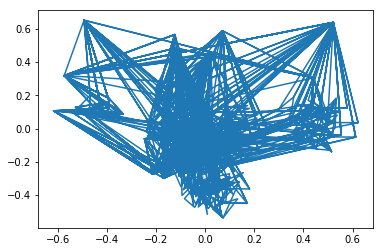

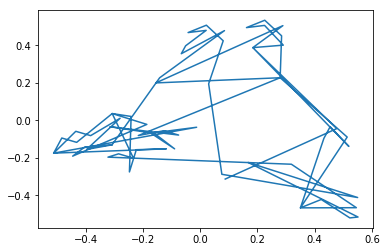

In [1075]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1076]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1077]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1078]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1079]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_44_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_U4XSYFQBYJ.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_49LZO54JCA.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -7.54893677e-02   7.88230784e-03   1.46600476e-01  -1.56988570e-02
  -5.41581062e-02   1.07497526e-03  -4.20443555e-02  -4.31109319e-02
  -3.58017760e-02   2.57290045e-02  -1.64979086e-02   7.27678623e-02
  -1.45560295e-02  -2.39397258e-03  -5.56036087e-02   3.19874136e-02
   1.3931

In [1080]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1081]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_44.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000004e+09   1.00000002e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1082]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0138010446035
Adjusted Rand Score: 0.00834245789666

[0 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 1 1 1 1 1 0 0 1 1 0 0 1 0 0 0 0 0 0 1 1
 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1 1 0 1 0 1 0]


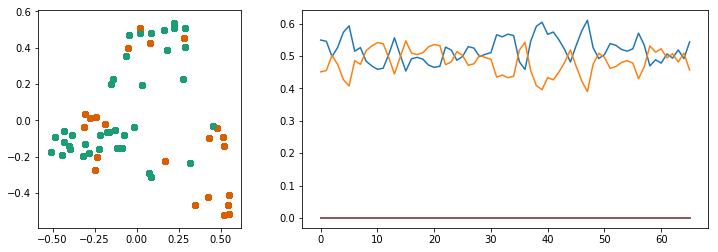

In [1083]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


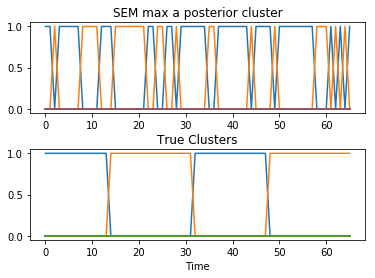

In [1084]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #45: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 40, 2, 400


In [1085]:
# Ensure reproducibility
#
np.random.seed(45)


In [1086]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_declines', 'verb'), ('Olivia', 'Subject')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('mousse', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('latte', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Order_drink', 'verb'), ('Olivia', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Julian', 'Emcee'), ('Pradeep', 'Poet')], [('Poet_performs', 'verb'), ('Pradeep', 'Poet')], [('Subject_declines', 'v

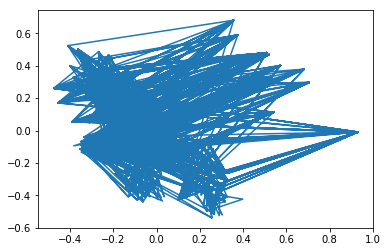

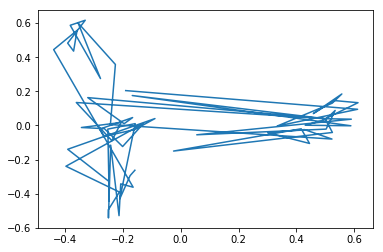

In [1087]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1088]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1089]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1090]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1091]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_45_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_JTASDQD7EK.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_EMBMXL99U3.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [  1.78646436e-03  -5.40955946e-02   4.35385360e-02  -4.47979451e-02
   1.32965343e-03   6.43282982e-02   5.27851037e-02   4.18349476e-03
   2.80579667e-02   1.19705355e-02  -5.81207853e-02   9.24044402e-03
   2.35310705e-02   1.65542902e-02   3.88016498e-02   7.40383480e-03
   7.3090

In [1092]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1093]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_45.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000006e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1094]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: 0.0101433027437
Adjusted Rand Score: 0.0179951973761

[0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 1 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


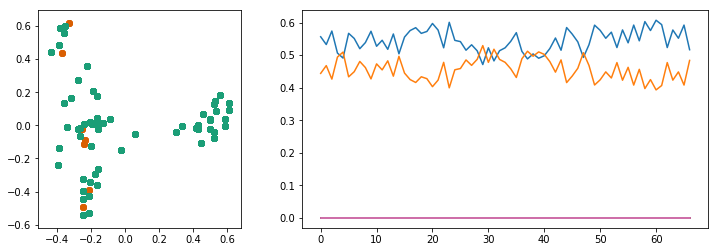

In [1095]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


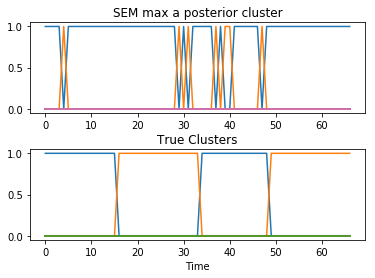

In [1096]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #46: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 40, 2, 400


In [1097]:
# Ensure reproducibility
#
np.random.seed(46)


In [1098]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Olivia', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_performs', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Pradeep', 'Subject'), ('Mariko', 'Friend')], [('END', 'verb'), ('Pradeep', 'Subject')], [('BEGIN', 'verb'), ('Sarah', 'Subject')], [('Order_drink', 'verb'), ('Sarah', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Sarah', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Will', 'Emcee'), ('Mariko', 'Poet')], [('Poet_performs', 'verb'), ('Mariko', 'Poet')], [('Subject_declines', 'verb'), ('Sarah', 'Subject')], [('Say_goodbye', 'verb'), ('Sarah', 'Subject'), (

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_performs', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('cake', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Julian', 'Subject')], [('Order_drink', 'verb'), ('Julian', 'Subject'), ('tea', 'Drink_bought')], [('Sit_down', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('Poet_performs', 'verb'), ('Will', 'Poet')], [('Subject_performs', 'verb'), ('Julian', 'Subject'), ('Sarah', 'Friend')], [('Say_goodbye', 'verb'), 

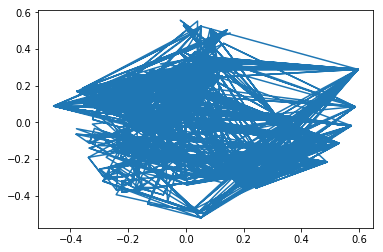

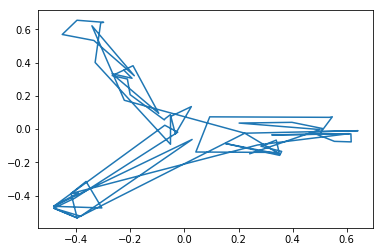

In [1099]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1100]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1101]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1102]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1103]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_46_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_9549PXKKQM.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_6SBMH3KHRD.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -3.33386760e-02   2.88213799e-02   2.83666181e-02   9.01109834e-03
  -3.81112795e-02   9.00031628e-02  -2.25191679e-02  -2.18066341e-02
   2.36541129e-02   1.23873291e-02   1.88563402e-02  -2.65061947e-02
  -1.21870135e-03  -4.07185611e-02   3.87162944e-02  -3.51082848e-02
   4.2792

In [1104]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1105]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_46.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000005e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1106]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.00736005651469
Adjusted Rand Score: -0.000601777445088

[0 0 0 0 1 0 0 0 1 1 1 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0]


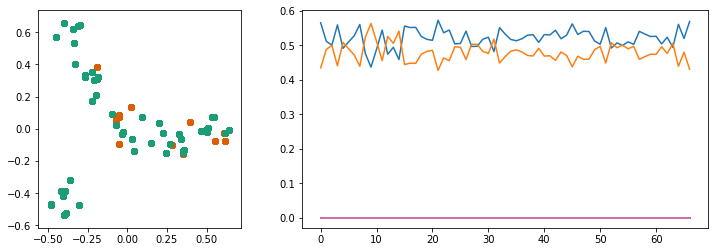

In [1107]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


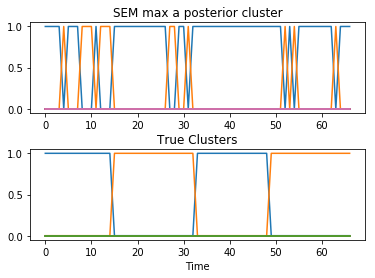

In [1108]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()


# Running test #47: CoffeeShopWorldData with params 2, 2, 400 with pretraining params 40, 2, 400


In [1109]:
# Ensure reproducibility
#
np.random.seed(47)


In [1110]:
# Load pretrain data
# 
pretrain_data = CoffeeShopWorldData(40,2,400)
#pretrain_data.plot_scenes()


Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Emcee_intro', 'verb'), ('Sarah', 'Emcee'), ('Olivia', 'Poet')], [('Poet_performs', 'verb'), ('Olivia', 'Poet')], [('Subject_declines', 'verb'), ('Will', 'Subject')], [('Say_goodbye', 'verb'), ('Will', 'Subject'), ('Julian', 'Friend')], [('Order_dessert', 'verb'), ('Will', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Will', 'Subject')], [('BEGIN', 'verb'), ('Will', 'Subject')], [('Order_drink', 'verb'), ('Will', 'Subject'), ('latte', 'Drink_bought')], [('Too_expensive', 'verb'), ('Will', 'Subject')], [('Sit_down', 'verb'), ('Will', 'Subject'), ('Mariko', 'Friend')], [('Emcee_intro', 'verb'), ('Pradeep', 'Emcee'), ('Ju

Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/poetry.txt
Schema = /Users/momchil/Dropbox/Research/event cognition/narrative/schema/fight.txt
[[('BEGIN', 'verb'), ('Olivia', 'Subject')], [('Sit_down', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Poet_performs', 'verb'), ('Julian', 'Poet')], [('Subject_performs', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Say_goodbye', 'verb'), ('Olivia', 'Subject'), ('Pradeep', 'Friend')], [('Order_dessert', 'verb'), ('Olivia', 'Subject'), ('sorbet', 'Dessert_bought')], [('END', 'verb'), ('Olivia', 'Subject')], [('BEGIN', 'verb'), ('Pradeep', 'Subject')], [('Order_drink', 'verb'), ('Pradeep', 'Subject'), ('coffee', 'Drink_bought')], [('Sit_down', 'verb'), ('Pradeep', 'Subject'), ('Olivia', 'Friend')], [('Emcee_intro', 'verb'), ('Mariko', 'Emcee'), ('Sarah', 'Poet')], [('Poet_performs', 'verb'), ('Sarah', 'Poet')], [('Subject_declines', 'verb'), ('Pradeep', 'Subject')], [('Say_goodbye', 'verb'), (

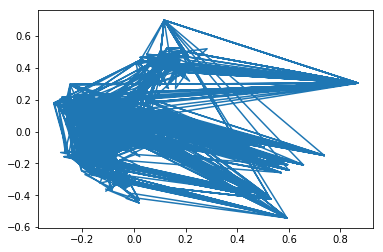

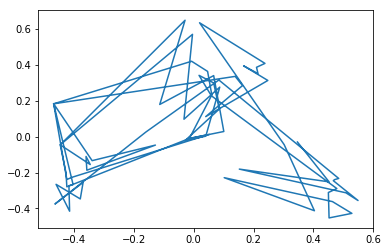

In [1111]:
# Load test data
# 
test_data = CoffeeShopWorldData(2,2,400)
pretrain_data.plot_scenes()
test_data.plot_scenes()


In [1112]:
# Set SEM parameters
#
D = test_data.D
t_horizon = 5 # time horizon to consider

# parameters for schocastic gradient descent 
sgd_kwargs = {
    'nesterov': True, 
    'lr': 0.1, 
    'momentum': 0.5, 
    'decay': 0.001
}

# specify the model architecture (makes a big difference! especially the training parameters)
f_class = KerasSimpleRNN
f_opts = dict(t=t_horizon, n_epochs=200, sgd_kwargs=sgd_kwargs,
              n_hidden1=D, n_hidden2=D, 
              hidden_act1='relu', hidden_act2='relu',
              l2_regularization=0.01,
              dropout=0.50)

lmda = 10.
alfa = 10.0

# note! the likelihood function needs to be scaled with the dimensionality of the vectors
# to compensate for the natural sharpening of the likelihood function as the dimensionality expands
beta = 0.15 * D * np.var(test_data.X.flatten()) # this equals 1 if the data are scaled
beta = 0.15
Omega = {
    'lmda': lmda,  # Stickyness (prior)
    'alfa': alfa, # Concentration parameter (prior)
    'beta': beta, # Likelihood noise
    'f_class': f_class,
    'f_opts': f_opts
}
print 'lambda =', lmda
print 'alpha =', alfa
print 'beta =', beta


lambda = 10.0
alpha = 10.0
beta = 0.15


In [1113]:
# Initialize SEM
# 
K = test_data.X.shape[0]
sem = SEM(**Omega)


In [1114]:
# Pretrain SEM
# 
#sem.pretrain(pretrain_data.X, pretrain_data.y)


In [1115]:
# Alternatively, load pretrained SEM from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_47_pretrain.pkl')
sem.deserialize(res['sem'])


Deserializing SEM object ...
      setting  C  to  [  1.00000000e+09   1.00000000e+09]
      setting  D  to  400
      setting  K  to  2
      setting  alfa  to  10.0
      setting  beta  to  0.15
       loading event model 0  from  output_9N1P1QINCS/event_model_weights_AW1Z1CDH4M.h5
       loading event model 1  from  output_9N1P1QINCS/event_model_weights_GNDOUR97C6.h5
      setting  f_opts  to  {'n_hidden2': 400, 'n_hidden1': 400, 'dropout': 0.5, 'hidden_act1': 'relu', 'hidden_act2': 'relu', 'n_epochs': 200, 't': 5, 'sgd_kwargs': {'nesterov': True, 'lr': 0.1, 'momentum': 0.5, 'decay': 0.001}, 'l2_regularization': 0.01}
      setting  k_prev  to  1
      setting  lmda  to  10.0
      setting  x_prev  to  [ -3.99558739e-02   5.90560936e-02   4.21493935e-02  -2.64350078e-02
   6.54370508e-03  -5.57791852e-02   5.46165850e-02  -3.51484777e-02
  -3.81158981e-02   2.44362156e-02  -4.87352886e-02  -9.93485108e-04
   7.48878419e-02  -5.15939983e-02  -2.36328595e-03   4.26072293e-03
   3.4411

In [1116]:
# Run SEM
# 
#post, pe, log_lik, log_prior = sem.run(test_data.X, K=K, return_pe=True, return_lik_prior=True)


In [1117]:
# Alternatively, load results from past execution
#
res = read_pickle('output_9N1P1QINCS/test_results_9N1P1QINCS_47.pkl')
sem.deserialize(res['sem'])
post = res['post']


Deserializing SEM object ...
      setting  C  to  [  1.00000005e+09   1.00000001e+09   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00 

In [1118]:
# Evaluate performance
# 
y_hat = np.argmax(post, axis=1)
mi = metrics.adjusted_mutual_info_score(test_data.y, y_hat)
print "Adjusted Mutual Information:", mi
r = metrics.adjusted_rand_score(test_data.y, y_hat)
print "Adjusted Rand Score:", r
print 
print np.argmax(post, axis=1)


Adjusted Mutual Information: -0.00219712571842
Adjusted Rand Score: 0.00626943905405

[1 0 0 1 1 1 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 1 1 0 0 0 0 0 0 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0]


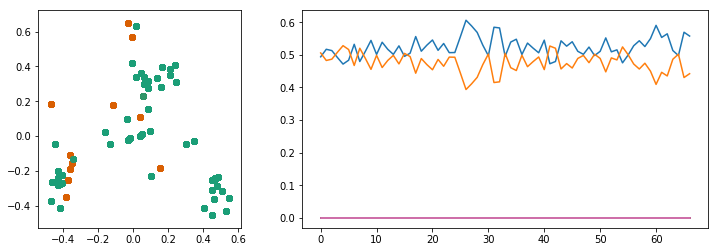

In [1119]:
# Plot posterior
# 
if test_data.D == 2:
    X = test_data.X
else:
    # if scenes are > 2 dimensional, run PCA first (this is for plotting only)
    pca = PCA(n_components=2)
    pca.fit(test_data.X)
    X = pca.transform(test_data.X)
cluster_id = np.argmax(post, axis=1)
cc = sns.color_palette('Dark2', post.shape[1])

fig, axes = plt.subplots(1, 2, figsize=(12, 4), gridspec_kw=dict(width_ratios=[1, 2]))
for clt in cluster_id:
    idx = np.nonzero(cluster_id == clt)[0]
    axes[0].scatter(X[idx, 0], X[idx, 1], color=cc[clt], alpha=.5)
    
axes[1].plot(post)
plt.show()


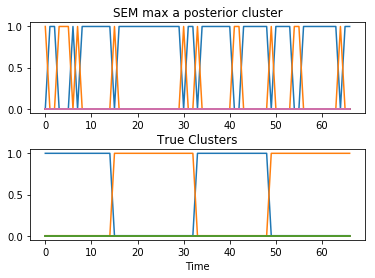

In [1120]:
# Plot clusters
# 
fig, axes = plt.subplots(2, 1)
max_post = np.zeros(post.shape)
for t in range(post.shape[0]):
    max_post[t, :] = post[t, :] == post[t, :].max()
axes[0].plot(max_post)
axes[0].set_title('SEM max a posterior cluster')
y_clust = np.zeros((test_data.y.shape[0], 13))
for ii, y0 in enumerate(test_data.y):
    y_clust[ii, y0] = 1.0
axes[1].plot(y_clust)
axes[1].set_title('True Clusters')
axes[1].set_xlabel('Time')
plt.subplots_adjust(hspace=0.4)
plt.show()
